# Preparation

In [1]:
!pwd
!pip install lifelines
! pip install sklearn-pandas
! pip install torchtuples
# ! pip install pycox

from google.colab import drive

drive.mount("/content/drive")

%cd "/content/drive/MyDrive/pycox"
%pwd
# from pycox.models import LogisticHazard

/content
     |████████████████████████████████| 349 kB 6.3 MB/s 
     |████████████████████████████████| 56 kB 2.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=8b182bb7b8c1548a35cc7d51bd0c6da5c179db45e81d5d50dca1533ce11fc0fc
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: astor
    Found existing installation: astor 0.8.1
    Uninstalling astor-0.8.1:
      Successfully uninstalled astor-0.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires astor~=0.8.1, b

     |████████████████████████████████| 41 kB 556 kB/s 
Mounted at /content/drive
/content/drive/MyDrive/pycox


'/content/drive/MyDrive/pycox'

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch # For building the networks 
import torchtuples as tt # Some useful functions

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [4]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A4 folder, then "2022WI/A4"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Kevin He"
GOOGLE_DRIVE_PATH = os.path.join("/content/drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['local_data.csv', 'prior_data.csv', 'local_data_2.csv', 'local_data_3.csv', 'prior_data_subset.csv', 'prior_data_subset_2.csv', 'prior_data_subset_3.csv']


# Di's Data using Existing Model (nnet-survival)

## Loading Data and Preprocessing

In [ ]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_3.csv")

In [ ]:
# data_local = data_local.drop(['Unnamed: 0', "LP_prior1"], axis = 1)
data_local = data_local.drop(['Unnamed: 0'], axis = 1)

# Due to the starter number difference between Python and R
data_local['time'] = data_local['time'] - 1

In [ ]:
data_local

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time
0,0,-0.086217,-0.597338,0.867489,-1.011658,0.007625,1,0,0,1,1,9
1,0,-0.519205,1.522403,0.907799,-0.502657,0.061186,1,1,0,0,1,6
2,0,0.044482,-0.796969,0.111709,2.241688,2.573551,0,0,1,0,0,9
3,0,0.185787,-1.022396,-0.451725,0.103989,1.703171,1,0,0,1,0,6
4,0,1.585913,1.230530,1.622750,2.273433,1.149133,0,1,0,1,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0.235759,-0.447568,0.607617,-0.010384,-0.635953,0,0,0,0,0,4
996,0,0.782171,0.182999,0.667356,0.349225,-0.166701,0,1,0,1,0,3
997,0,0.112882,0.549177,0.452166,0.478360,-0.225349,0,1,1,1,0,9
998,0,0.732930,1.053392,0.626755,0.227135,0.450755,1,0,1,0,1,4


In [ ]:
# Standardize for continuous data, remaining the same for categorical data

cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

data_local_mapper = DataFrameMapper(standardize + leave)

In [ ]:
data_local

data_local_test = data_local.sample(frac=0.2)
data_local_train = data_local.drop(data_local_test.index)
data_local_val = data_local_train.sample(frac=0.2)
data_local_train = data_local_train.drop(data_local_val.index)

In [ ]:
num_durations = np.max(data_local['time'])

In [ ]:
data_local_train

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time
0,0,-0.086217,-0.597338,0.867489,-1.011658,0.007625,1,0,0,1,1,9
2,0,0.044482,-0.796969,0.111709,2.241688,2.573551,0,0,1,0,0,9
3,0,0.185787,-1.022396,-0.451725,0.103989,1.703171,1,0,0,1,0,6
4,0,1.585913,1.230530,1.622750,2.273433,1.149133,0,1,0,1,1,9
5,0,1.049613,1.888221,2.495762,1.658407,1.285324,0,1,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
992,0,0.212382,1.220279,0.277712,0.938756,2.058708,0,1,0,1,0,3
993,0,-0.298909,0.406672,0.384965,0.338046,1.589584,0,1,0,1,0,7
996,0,0.782171,0.182999,0.667356,0.349225,-0.166701,0,1,0,1,0,3
997,0,0.112882,0.549177,0.452166,0.478360,-0.225349,0,1,1,1,0,9


In [ ]:
x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
x_val = data_local_mapper.transform(data_local_val).astype('float32')
x_test = data_local_mapper.transform(data_local_test).astype('float32')

In [ ]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['status'].values)
y_train = labtrans.fit_transform(*get_target(data_local_train))
y_val = labtrans.transform(*get_target(data_local_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(data_local_test)

In [ ]:
labtrans.cuts

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
# time_array = np.array(data_local_train['time'])
# status_array = np.array(data_local_train['status'])
# y_train = (time_array, status_array)

# time_array = np.array(data_local_val['time'])
# status_array = np.array(data_local_val['status'])
# y_val = (time_array, status_array)

## Model Training

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [ ]:
# num_durations = 10

# labtrans = LogisticHazard.label_transform(num_durations)
# # labtrans = PMF.label_transform(num_durations)
# # labtrans = DeepHitSingle.label_transform(num_durations)

# get_target = lambda df: (df['duration'].values, df['event'].values)
# y_train = labtrans.fit_transform(*get_target(df_train))
# y_val = labtrans.transform(*get_target(df_val))

# train = (x_train, y_train)
# val = (x_val, y_val)

# # We don't need to transform the test labels
# durations_test, events_test = get_target(df_test)

In [ ]:
# df_train = metabric.read_df()
# df_test = df_train.sample(frac=0.2)
# df_train = df_train.drop(df_test.index)
# df_val = df_train.sample(frac=0.2)
# df_train = df_train.drop(df_val.index)

Dataset 'metabric' not locally available. Downloading...
Done


In [ ]:
# df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [ ]:
# cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
# cols_leave = ['x4', 'x5', 'x6', 'x7']

# standardize = [([col], StandardScaler()) for col in cols_standardize]
# leave = [(col, None) for col in cols_leave]

# x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
# x_train = x_mapper.fit_transform(df_train).astype('float32')
# x_val = x_mapper.transform(df_val).astype('float32')
# x_test = x_mapper.transform(df_test).astype('float32')

In [ ]:
# num_durations = 10

# labtrans = LogisticHazard.label_transform(num_durations)
# # labtrans = PMF.label_transform(num_durations)
# # labtrans = DeepHitSingle.label_transform(num_durations)

# get_target = lambda df: (df['duration'].values, df['event'].values)
# y_train = labtrans.fit_transform(*get_target(df_train))
# y_val = labtrans.transform(*get_target(df_val))

# train = (x_train, y_train)
# val = (x_val, y_val)

# # We don't need to transform the test labels
# durations_test, events_test = get_target(df_test)

In [ ]:
# in_features = x_train.shape[1]
# num_nodes = [32, 32]
# out_features = labtrans.out_features
# batch_norm = True
# dropout = 0.1

# net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [ ]:
import torch
import torch.nn.functional as F
A = torch.tensor([[0.3, 0.4, 0.5], [0.3, 0.4, 0.5]])
B = torch.tensor([[0.9, 0.4, 0.8], [0.9, 0.4, 0.8]])
F.binary_cross_entropy_with_logits(A, B, reduction="none")

tensor([[0.5844, 0.7530, 0.5741],
        [0.5844, 0.7530, 0.5741]])

In [ ]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [ ]:
batch_size = 20
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [ ]:
y_train

# TODO: Fill in the data with the expanded version of data in the first line

(array([9, 9, 6, 9, 2, 1, 3, 2, 9, 9, 0, 3, 8, 9, 2, 7, 7, 6, 2, 3, 4, 2,
        9, 4, 1, 7, 1, 1, 1, 1, 5, 3, 6, 1, 4, 6, 9, 9, 9, 6, 1, 2, 1, 2,
        4, 7, 7, 9, 8, 5, 7, 2, 7, 5, 8, 5, 6, 3, 2, 5, 8, 7, 4, 7, 4, 8,
        5, 8, 3, 0, 6, 8, 6, 3, 8, 8, 9, 4, 5, 8, 5, 0, 7, 2, 7, 0, 4, 9,
        6, 5, 2, 8, 1, 1, 9, 5, 0, 2, 1, 3, 5, 7, 9, 2, 0, 7, 1, 9, 1, 1,
        9, 3, 1, 9, 3, 3, 8, 1, 9, 0, 4, 4, 6, 8, 3, 2, 6, 5, 8, 3, 5, 6,
        7, 5, 6, 5, 4, 7, 8, 4, 7, 1, 3, 5, 6, 6, 2, 5, 1, 7, 3, 6, 1, 9,
        9, 3, 3, 5, 9, 3, 7, 6, 7, 9, 5, 8, 3, 7, 4, 7, 5, 7, 9, 2, 8, 1,
        9, 2, 2, 0, 4, 7, 3, 6, 7, 9, 8, 8, 5, 3, 6, 9, 5, 6, 3, 8, 2, 4,
        3, 4, 5, 7, 9, 6, 9, 2, 5, 3, 9, 2, 5, 1, 2, 6, 8, 4, 9, 5, 0, 7,
        3, 8, 4, 2, 2, 8, 4, 3, 6, 3, 5, 2, 3, 5, 5, 6, 1, 5, 2, 3, 2, 7,
        4, 6, 5, 1, 4, 2, 6, 1, 9, 9, 9, 9, 6, 4, 7, 6, 7, 2, 6, 6, 4, 2,
        9, 5, 6, 9, 1, 8, 5, 9, 4, 6, 5, 4, 9, 5, 6, 7, 4, 6, 8, 4, 3, 6,
        3, 2, 3, 9, 4, 7, 4, 6, 9, 9, 

In [ ]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 3.0857,	val_loss: 1.3113
1:	[0s / 0s],		train_loss: 0.7263,	val_loss: 0.3173
2:	[0s / 0s],		train_loss: 0.4282,	val_loss: 0.2297
3:	[0s / 0s],		train_loss: 0.3804,	val_loss: 0.2027
4:	[0s / 0s],		train_loss: 0.3492,	val_loss: 0.1992
5:	[0s / 0s],		train_loss: 0.3356,	val_loss: 0.2174
6:	[0s / 0s],		train_loss: 0.3209,	val_loss: 0.1931
7:	[0s / 0s],		train_loss: 0.3142,	val_loss: 0.2228
8:	[0s / 0s],		train_loss: 0.3152,	val_loss: 0.2209
9:	[0s / 0s],		train_loss: 0.3032,	val_loss: 0.1899
10:	[0s / 0s],		train_loss: 0.2736,	val_loss: 0.2086
11:	[0s / 1s],		train_loss: 0.2903,	val_loss: 0.1756
12:	[0s / 1s],		train_loss: 0.2684,	val_loss: 0.1861
13:	[0s / 1s],		train_loss: 0.2839,	val_loss: 0.1794
14:	[0s / 1s],		train_loss: 0.2470,	val_loss: 0.1913
15:	[0s / 1s],		train_loss: 0.2768,	val_loss: 0.1687
16:	[0s / 1s],		train_loss: 0.2588,	val_loss: 0.1977
17:	[0s / 1s],		train_loss: 0.2654,	val_loss: 0.2171
18:	[0s / 1s],		train_loss: 0.2822,	val_loss: 0.2001
19:

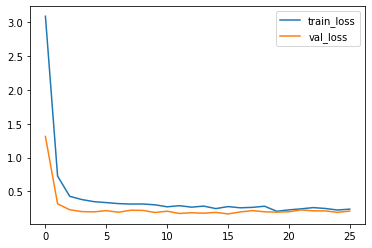

In [ ]:
_ = log.plot()

In [ ]:
log.to_pandas().val_loss.min()

0.3163011968135834

In [ ]:
model.score_in_batches(val)

{'loss': 0.16871365904808044}

## Model Prediction

In [ ]:
surv = model.predict_surv_df(x_test)

In [ ]:
surv

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0.0,0.999870,0.999375,0.999969,0.999880,0.998860,0.998381,0.999700,0.999071,0.999397,0.976803,...,0.999369,0.998748,0.999229,0.999900,0.999770,0.999753,0.998522,0.999353,0.995016,0.999493
1.0,0.999599,0.998110,0.999957,0.999834,0.998541,0.997144,0.999549,0.998131,0.999125,0.971048,...,0.998276,0.997100,0.998410,0.999831,0.999531,0.999343,0.997846,0.998388,0.990902,0.999135
2.0,0.999348,0.997156,0.999928,0.999666,0.998465,0.995245,0.999127,0.996373,0.997712,0.956262,...,0.997065,0.994466,0.997492,0.999572,0.999215,0.998948,0.996479,0.997774,0.988698,0.998393
3.0,0.999222,0.995767,0.999580,0.999507,0.997382,0.993181,0.996198,0.994930,0.997183,0.708951,...,0.996515,0.993822,0.996071,0.998371,0.994779,0.997116,0.995995,0.995771,0.983610,0.997568
4.0,0.998735,0.990750,0.999435,0.999280,0.995996,0.989544,0.994369,0.991405,0.995897,0.691823,...,0.994864,0.992108,0.991464,0.997825,0.992115,0.994336,0.994512,0.991942,0.971664,0.996113
5.0,0.998375,0.988334,0.999181,0.998487,0.995141,0.987057,0.989484,0.988688,0.992392,0.502293,...,0.993214,0.989662,0.989440,0.996513,0.988886,0.992571,0.993325,0.989971,0.964783,0.994143
6.0,0.998234,0.985350,0.998463,0.997897,0.969825,0.982224,0.981499,0.951367,0.988319,0.382843,...,0.992200,0.988300,0.973609,0.994192,0.979770,0.978724,0.991838,0.971633,0.799992,0.990521
7.0,0.998125,0.983407,0.997664,0.995721,0.968460,0.973550,0.972234,0.946409,0.981022,0.255968,...,0.990902,0.984577,0.968383,0.992342,0.977603,0.976419,0.990190,0.967940,0.794067,0.983810
8.0,0.997749,0.976155,0.997098,0.995476,0.917211,0.969105,0.963913,0.933795,0.978521,0.232715,...,0.988908,0.982362,0.959701,0.988879,0.934397,0.965504,0.989179,0.952219,0.632242,0.982095
9.0,0.997178,0.958208,0.996078,0.993526,0.912727,0.958428,0.961182,0.922072,0.970538,0.226753,...,0.977381,0.946715,0.951647,0.987604,0.932018,0.961220,0.984877,0.940516,0.615042,0.977596


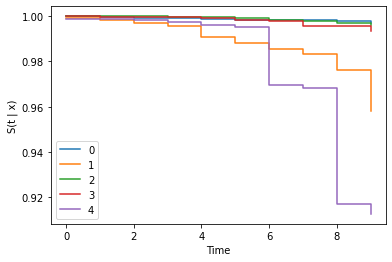

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
surv = model.interpolate(10).predict_surv_df(x_test)

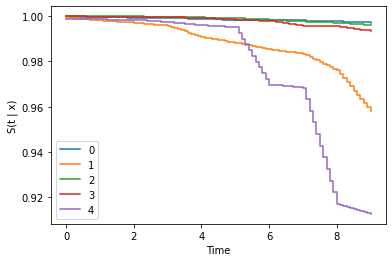

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Model Evaluation

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [ ]:
ev.concordance_td('antolini')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


0.9606741573033708

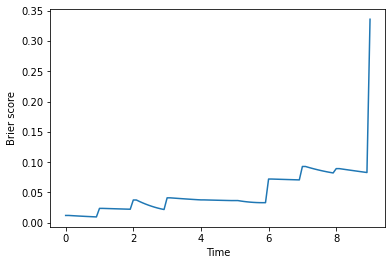

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

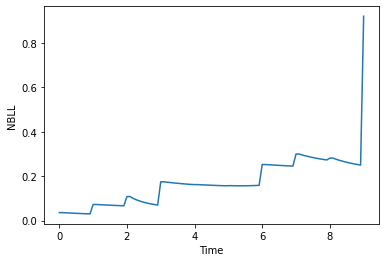

In [ ]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [ ]:
ev.integrated_brier_score(time_grid) 

0.04814854433525179

In [ ]:
ev.integrated_nbll(time_grid) 

0.16779966545012004

# Di's Data using KL-divergence

## Loading Data

In [5]:
def dataLong(x):
  Sum = x['time'].sum()
  y = np.zeros((Sum, ))
  indices = np.array(x['time'].cumsum() - 1)
  indices_2 = x["status"] == 1
  indices = indices[indices_2]
  y[indices] = 1

  time_2 = []
  time = np.array(x['time']).tolist()
  for j in time:
    time_2.extend([(i + 1) for i in range(j)])

  columns = x.columns
  x_np = np.array(x)
  n_row = x.shape[0]
  x_long = None
  for i in range(n_row):
    x_np_single = x_np[i]
    x_np_single = np.tile(x_np_single, (time[i], 1))
    if(x_long is None):
      x_long = x_np_single
    else:
      x_long = np.concatenate((x_long, x_np_single), axis = 0)
  
  x = pd.DataFrame(x_long)
  x.columns = columns
  x["y"] = y
  x["time"] = time_2

  time = x["time"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 11))
  np.put_along_axis(zeros, time, 1, axis=1)
  zeros = zeros[:, 1:]

  columns = ['time' + str(i + 1) for i in range(10)]
  x[columns] = zeros

  return x

In [6]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")

In [7]:
data_local = data_local.drop(['Unnamed: 0'], axis = 1)

In [8]:
data_local

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time,LP_prior1
0,0,0.753965,1.627692,0.105189,-0.615590,-1.715804,1,1,0,0,1,5,-1.958141
1,0,0.276078,-0.087196,0.264314,0.638372,-0.265806,0,1,0,1,0,6,-6.177399
2,0,0.057311,-1.433433,-1.697019,-0.457663,-0.901141,0,0,0,1,0,10,-1.676150
3,0,-1.223157,0.730813,0.737298,-0.025978,1.042561,1,0,0,1,1,10,-4.000056
4,0,-0.196961,0.517777,-0.218232,0.115463,-1.293901,0,1,1,0,0,8,-2.251158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,-0.124636,-1.061005,0.118523,-1.367860,-1.624387,0,1,0,0,1,7,3.342440
296,0,-0.646082,0.860371,0.197020,0.577851,2.013423,1,1,0,1,1,4,-3.850736
297,0,0.696193,0.668141,0.701740,1.373414,1.983840,1,0,1,1,1,4,-13.846852
298,1,0.508184,0.546064,-1.160606,-1.284907,0.534088,1,1,1,0,1,7,1.142217


In [9]:
data_prior = pd.read_csv("/content/drive/My Drive/Kevin He/prior_data.csv")

In [10]:
data_prior

,Unnamed: 0,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time
0,1,0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0,1,0,1,1,7
1,2,0,0.167797,-1.079335,-0.835810,1.251037,1.663017,1,1,0,1,1,9
2,3,0,-0.890850,-1.860280,-1.438631,-1.767561,-1.651210,0,1,1,1,1,6
3,4,0,0.503094,0.138824,-0.481668,-0.958850,-1.150178,1,1,1,0,1,7
4,5,0,-0.137754,1.030716,-0.069327,0.637014,0.618091,1,1,1,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0,-0.915949,-0.087417,0.033986,-0.848910,-0.534234,0,0,1,1,1,5
9996,9997,0,-1.179707,-1.155198,-1.648140,0.384699,1.118215,0,1,1,0,1,3
9997,9998,0,1.233159,-0.280681,0.073404,-1.476220,-0.040967,0,0,1,0,0,3
9998,9999,0,0.011310,0.479807,-0.279155,1.167471,-0.583554,0,1,1,1,0,10


In [11]:
data_prior = data_prior.drop(['Unnamed: 0'], axis = 1)

In [12]:
data_prior_expanded = dataLong(data_prior)

In [13]:
data_prior_expanded

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,...,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60116,0.0,1.164986,0.885852,0.307401,1.091856,-1.178330,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
60117,0.0,1.164986,0.885852,0.307401,1.091856,-1.178330,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60118,0.0,1.164986,0.885852,0.307401,1.091856,-1.178330,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60119,0.0,1.164986,0.885852,0.307401,1.091856,-1.178330,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Logistic Regression: Finding Parameters for prior data

In [43]:
columns = ["Z" + str(i + 1) for i in range(10)] + ['time' + str(i + 1) for i in range(10)]
# X = np.array(data_prior[columns])
# y = np.array(data_prior['y'])
X = data_prior_expanded[columns]
y = data_prior_expanded["y"]

KeyError: ignored

In [44]:
import statsmodels.api as sm

# train_x['intercept'] = 1.0
logit = sm.Logit(y, X)
result = logit.fit(maxiter = 10000)
result.summary()

Optimization terminated successfully.
         Current function value: 0.047001
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                59916
Model:                          Logit   Df Residuals:                    59898
Method:                           MLE   Df Model:                           17
Date:                Wed, 13 Apr 2022   Pseudo R-squ.:                  0.4838
Time:                        17:34:53   Log-Likelihood:                -2816.1
converged:                       True   LL-Null:                       -5455.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Z1            -1.5479      0.053    -29.212      0.000      -1.652      -1.444
Z2             0.7848      0.050     15.677      0.000       0.687       0.883
Z3            -1.6878      0.059    -28.795      0.000      -1.803      -1.573
Z4            -1.9389      0.059    -33.113      0.000      -2.054      -1.824
Z6            -3.3639      0.108    -31.224      0.000      -3.575      -3.153
Z7             0.8745      0.076     11.573      0.000       0.726       1.023
Z8            -2.4079      0.092    -26.136      0.000      -2.588      -2.227
Z9            -3.3363      0.108    -30.887      0.000      -3.548      -3.125
time1         -4.5957      0.128    -35.930      0.000      -4.846      -4.345
time2         -4.7979      0.137    -35.066      0.000      -5.066      -4.530
time3         -5.0184      0.157    -32.007      0.000      -5.326      -4.711
time4         -3.6387      0.121    -30.139      0.000      -3.875      -3.402
time5         -3.8012      0.142    -26.843      0.000      -4.079      -3.524
time6         -3.7738      0.158    -23.829      0.000      -4.084      -3.463
time7         -2.5402      0.128    -19.841      0.000      -2.791      -2.289
time8         -2.6804      0.159    -16.888      0.000      -2.991      -2.369
time9         -1.7058      0.145    -11.757      0.000      -1.990      -1.421
time10        -2.6346      0.266     -9.909      0.000      -3.156      -2.113
==============================================================================

Possibly complete quasi-separation: A fraction 0.43 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [45]:
time_column = ["time" + str(i + 1) for i in range(10)]
cova_column = ["Z" + str(i + 1) for i in range(10)]

beta_time = np.array(result.params[time_column])
beta_cova = np.array(result.params[cova_column])

KeyError: ignored

In [ ]:
Z = np.array(data_local[cova_column])
Z

In [ ]:
prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

In [ ]:
time = data_local["time"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 11))
np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
zeros = zeros[:, 1:]
zeros

In [46]:
eta = 10
combined_info = (zeros + eta * prior_info) / (1 + eta)
combined_info

array([[2.34241665e-03, 1.91452768e-03, 1.53632817e-03, ...,
        1.56699765e-02, 4.03757649e-02, 1.63908710e-02],
       [8.84948928e-05, 7.22967138e-05, 5.79918171e-05, ...,
        6.00493678e-04, 1.58952197e-03, 6.28607064e-04],
       [4.11105229e-03, 3.36128449e-03, 2.69813986e-03, ...,
        2.71996943e-02, 6.86860746e-02, 2.84341301e-02],
       ...,
       [1.24735114e-08, 1.01901679e-08, 8.17377475e-09, ...,
        8.46883383e-08, 2.24416452e-07, 8.86559455e-08],
       [4.08356869e-03, 3.33879482e-03, 2.68007402e-03, ...,
        2.70224653e-02, 6.82594497e-02, 2.82491153e-02],
       [1.26857655e-02, 1.03901084e-02, 8.35304262e-03, ...,
        7.96913291e-02, 1.84491507e-01, 8.30836174e-02]])

## Putting combined info into Deep Learning

### Our Model

In [477]:
# Due to the starter number difference between Python and R
data_local['time'] = data_local['time'] - 1

In [47]:
# Standardize for continuous data, remaining the same for categorical data

cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

data_local_mapper = DataFrameMapper(standardize + leave)

In [48]:
data_local

data_local_test = data_local.sample(frac=0.2)
data_local_train = data_local.drop(data_local_test.index)
data_local_val = data_local_train.sample(frac=0.2)
data_local_train = data_local_train.drop(data_local_val.index)

In [480]:
data_local_train

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time,LP_prior1
0,0,0.753965,1.627692,0.105189,-0.615590,-1.715804,1,1,0,0,1,4,-1.958141
1,0,0.276078,-0.087196,0.264314,0.638372,-0.265806,0,1,0,1,0,5,-6.177399
2,0,0.057311,-1.433433,-1.697019,-0.457663,-0.901141,0,0,0,1,0,9,-1.676150
3,0,-1.223157,0.730813,0.737298,-0.025978,1.042561,1,0,0,1,1,9,-4.000056
4,0,-0.196961,0.517777,-0.218232,0.115463,-1.293901,0,1,1,0,0,7,-2.251158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,0,-0.585137,0.696079,-0.648097,-1.894090,-0.032816,1,0,1,1,1,4,-1.118961
293,0,0.037692,-0.466744,-1.583093,-0.811462,-1.235570,1,0,0,0,1,3,0.718822
294,0,-0.823789,-1.429319,-0.449583,-1.025423,-1.065238,1,0,0,1,1,2,-3.758514
295,0,-0.124636,-1.061005,0.118523,-1.367860,-1.624387,0,1,0,0,1,6,3.342440


In [481]:
data_local_train_index = np.array(data_local_train.index)
data_local_val_index = np.array(data_local_val.index)

In [482]:
x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
x_val = data_local_mapper.transform(data_local_val).astype('float32')
x_test = data_local_mapper.transform(data_local_test).astype('float32')

In [47]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['status'].values)

# CHANGE HERE!!!
# y_train = labtrans.fit_transform(*get_target(data_local_train))
# y_val = labtrans.transform(*get_target(data_local_val))
n_train = data_local_train.shape[0]
n_val = data_local_val.shape[0]
y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)


train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(data_local_test)

In [48]:
labtrans.cuts

In [49]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [486]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

1


In [487]:
batch_size = 20
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [488]:
y_train

(array([[4.26612487e-04, 3.31807097e-04, 4.32913685e-04, ...,
         4.79918408e-03, 1.60507286e-02, 1.38403818e-02],
        [5.47415844e-06, 4.25720675e-06, 5.55505148e-06, ...,
         6.18755640e-05, 2.09514232e-04, 1.80221773e-04],
        [4.89450332e-04, 3.80686441e-04, 4.96679157e-04, ...,
         5.50217951e-03, 1.83683979e-02, 1.58445474e-02],
        ...,
        [4.66516606e-05, 3.62809675e-05, 4.73410125e-05, ...,
         5.27067554e-04, 1.78250463e-03, 1.53366143e-03],
        [7.04888338e-02, 5.57799974e-02, 7.14486058e-02, ...,
         4.42926811e-01, 6.93553779e-01, 6.67813192e-01],
        [5.40006007e-05, 4.19963092e-05, 5.47985382e-05, ...,
         6.10044634e-04, 2.06267845e-03, 1.77479862e-03]]),
 array([4, 5, 9, 9, 7, 5, 6, 2, 2, 8, 9, 1, 8, 6, 5, 1, 1, 8, 7, 4, 4, 9,
        1, 2, 4, 3, 7, 8, 6, 9, 9, 8, 5, 7, 9, 5, 9, 5, 7, 6, 1, 3, 8, 4,
        3, 2, 7, 5, 5, 3, 9, 9, 5, 4, 8, 9, 6, 9, 9, 9, 3, 4, 3, 6, 8, 2,
        9, 2, 8, 1, 5, 2, 8, 1, 3, 5, 4, 9,

In [489]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 4.0269,	val_loss: 3.2201
1:	[0s / 0s],		train_loss: 3.1754,	val_loss: 2.2931
2:	[0s / 0s],		train_loss: 2.0748,	val_loss: 1.3767
3:	[0s / 0s],		train_loss: 1.0579,	val_loss: 0.7178
4:	[0s / 0s],		train_loss: 0.5801,	val_loss: 0.4711
5:	[0s / 0s],		train_loss: 0.4341,	val_loss: 0.4166
6:	[0s / 0s],		train_loss: 0.4565,	val_loss: 0.4205
7:	[0s / 0s],		train_loss: 0.3997,	val_loss: 0.4025
8:	[0s / 0s],		train_loss: 0.3869,	val_loss: 0.3557
9:	[0s / 0s],		train_loss: 0.4038,	val_loss: 0.3600
10:	[0s / 0s],		train_loss: 0.3564,	val_loss: 0.3761
11:	[0s / 0s],		train_loss: 0.3520,	val_loss: 0.3877
12:	[0s / 0s],		train_loss: 0.3963,	val_loss: 0.3663
13:	[0s / 0s],		train_loss: 0.3476,	val_loss: 0.3641
14:	[0s / 0s],		train_loss: 0.3631,	val_loss: 0.3729
15:	[0s / 0s],		train_loss: 0.3819,	val_loss: 0.3648
16:	[0s / 0s],		train_loss: 0.3438,	val_loss: 0.3683
17:	[0s / 0s],		train_loss: 0.3663,	val_loss: 0.3652
18:	[0s / 0s],		train_loss: 0.3469,	val_loss: 0.3492
19:

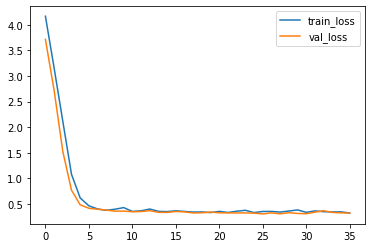

In [ ]:
_ = log.plot()

### Baseline (nnet-survival)

In [ ]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['status'].values)

# CHANGE HERE!!!
y_train = labtrans.fit_transform(*get_target(data_local_train))
y_val = labtrans.transform(*get_target(data_local_val))
# n_train = data_local_train.shape[0]
# n_val = data_local_val.shape[0]
# y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
# y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)


train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(data_local_test)

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [ ]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [ ]:
batch_size = 20
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [ ]:
y_train

# TODO: Fill in the data with the expanded version of data in the first line

(array([4, 5, 9, 9, 7, 5, 2, 2, 8, 3, 2, 8, 6, 5, 5, 1, 6, 1, 1, 7, 4, 4,
        1, 4, 7, 9, 9, 8, 9, 8, 5, 5, 9, 8, 5, 9, 5, 4, 7, 9, 6, 9, 6, 1,
        4, 3, 3, 2, 3, 6, 0, 4, 8, 7, 9, 9, 9, 9, 7, 3, 1, 2, 7, 5, 8, 2,
        9, 2, 4, 2, 5, 5, 8, 2, 8, 1, 1, 3, 4, 9, 7, 1, 1, 9, 8, 4, 4, 7,
        1, 8, 5, 3, 9, 4, 6, 1, 2, 3, 9, 2, 9, 5, 2, 7, 5, 3, 0, 6, 9, 8,
        7, 8, 4, 9, 7, 4, 2, 3, 2, 5, 4, 4, 6, 9, 0, 7, 9, 9, 5, 4, 9, 2,
        8, 4, 1, 1, 3, 9, 1, 4, 8, 8, 1, 4, 0, 4, 9, 5, 8, 8, 8, 3, 4, 6,
        3, 3, 8, 4, 1, 0, 1, 2, 3, 4, 4, 9, 9, 3, 8, 6, 7, 2, 7, 0, 4, 5,
        5, 4, 4, 4, 2, 2, 5, 4, 8, 8, 4, 4, 3, 2, 3, 5]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0.

In [ ]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 3.9768,	val_loss: 3.6329
1:	[0s / 0s],		train_loss: 3.0612,	val_loss: 2.6323
2:	[0s / 0s],		train_loss: 1.9888,	val_loss: 1.4241
3:	[0s / 0s],		train_loss: 1.0475,	val_loss: 0.6004
4:	[0s / 0s],		train_loss: 0.5119,	val_loss: 0.3142
5:	[0s / 0s],		train_loss: 0.3585,	val_loss: 0.2408
6:	[0s / 0s],		train_loss: 0.4046,	val_loss: 0.2461
7:	[0s / 0s],		train_loss: 0.2765,	val_loss: 0.2673
8:	[0s / 0s],		train_loss: 0.2524,	val_loss: 0.2568
9:	[0s / 0s],		train_loss: 0.2570,	val_loss: 0.2689
10:	[0s / 0s],		train_loss: 0.2409,	val_loss: 0.2847
11:	[0s / 0s],		train_loss: 0.2279,	val_loss: 0.3007
12:	[0s / 0s],		train_loss: 0.1891,	val_loss: 0.2675
13:	[0s / 0s],		train_loss: 0.2059,	val_loss: 0.2672
14:	[0s / 0s],		train_loss: 0.1872,	val_loss: 0.2696
15:	[0s / 0s],		train_loss: 0.1691,	val_loss: 0.2750


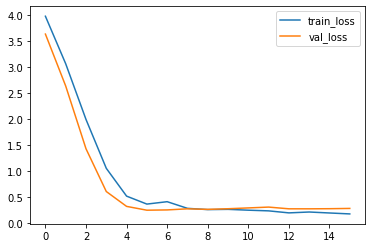

In [ ]:
_ = log.plot()

In [ ]:
log.to_pandas().val_loss.min()

0.24076062440872192

## Evaluation

In [ ]:
surv = model.predict_surv_df(x_test)

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


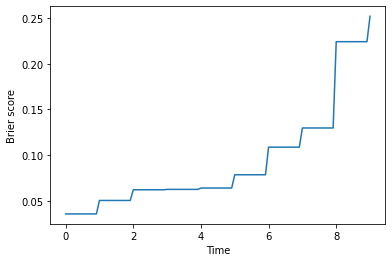

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

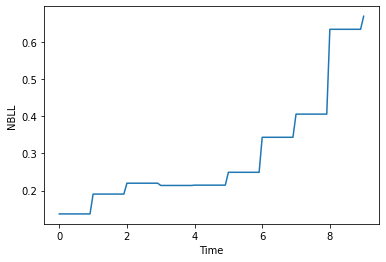

In [ ]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [ ]:
ev.integrated_brier_score(time_grid) 

0.09176995443645528

In [ ]:
ev.integrated_nbll(time_grid) 

0.29252012928659815

# Multiple Experiments

In [490]:
concordance_td_list = []
integrated_brier_score_list = []
integrated_nbll_list = []
likelihood_list = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  train = (x_train, y_train)
  val = (x_val, y_val)


  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list.append(ev.concordance_td('antolini'))
  integrated_brier_score_list.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list.append(ev.integrated_nbll(time_grid))
  likelihood_list.append(log.to_pandas().val_loss.min())


1
0:	[0s / 0s],		train_loss: 4.1322,	val_loss: 3.3134
1:	[0s / 0s],		train_loss: 3.1980,	val_loss: 2.4721
2:	[0s / 0s],		train_loss: 2.1428,	val_loss: 1.3725
3:	[0s / 0s],		train_loss: 1.1785,	val_loss: 0.6913
4:	[0s / 0s],		train_loss: 0.5554,	val_loss: 0.4834
5:	[0s / 0s],		train_loss: 0.4165,	val_loss: 0.3982
6:	[0s / 0s],		train_loss: 0.4171,	val_loss: 0.3998
7:	[0s / 0s],		train_loss: 0.4339,	val_loss: 0.3705
8:	[0s / 0s],		train_loss: 0.3726,	val_loss: 0.3535
9:	[0s / 0s],		train_loss: 0.4040,	val_loss: 0.3606
10:	[0s / 0s],		train_loss: 0.3595,	val_loss: 0.3679
11:	[0s / 0s],		train_loss: 0.3739,	val_loss: 0.3576
12:	[0s / 0s],		train_loss: 0.3913,	val_loss: 0.3724
13:	[0s / 0s],		train_loss: 0.3595,	val_loss: 0.3819
14:	[0s / 0s],		train_loss: 0.3611,	val_loss: 0.3777
15:	[0s / 0s],		train_loss: 0.3896,	val_loss: 0.3833
16:	[0s / 0s],		train_loss: 0.3510,	val_loss: 0.3715
17:	[0s / 0s],		train_loss: 0.3634,	val_loss: 0.3493
18:	[0s / 0s],		train_loss: 0.3914,	val_loss: 0.3536
1

In [491]:
concordance_td_list 
integrated_brier_score_list 
integrated_nbll_list 
likelihood_list

[0.349329922972589,
 0.3472660398060184,
 0.3269994588104648,
 0.33450067420569124,
 0.3213987057469113,
 0.3637501666966594,
 0.34041408378017346,
 0.3362658454873575,
 0.330974805029255,
 0.33821225236177677,
 0.3385903526937584,
 0.33062476508765165,
 0.3227176953845859,
 0.3383718873733701,
 0.3248734814166397,
 0.3360329730814902,
 0.35222445085994564,
 0.3295880104304835,
 0.32685825915258926,
 0.31656023473694533,
 0.32825633717029334,
 0.3588385967789513,
 0.32417230276112885,
 0.33443187188365214,
 0.34174823650891745,
 0.33332452769719856,
 0.34792525965063453,
 0.3212760372714475,
 0.33164411292887735,
 0.3276066114071601,
 0.34621710401640504,
 0.3365599615112573,
 0.32451274129097124,
 0.34253582258792026,
 0.3391626260567146,
 0.33125357334559574,
 0.3552684074544761,
 0.3423434572412399,
 0.344027552484828,
 0.33948446792950215,
 0.3502743983081593,
 0.32138118774884145,
 0.3697416527209862,
 0.3356615034156832,
 0.33825137496754537,
 0.35136042886360475,
 0.334979214954

In [492]:
concordance_td_list_old = []
integrated_brier_score_list_old = []
integrated_nbll_list_old = []
likelihood_list_old = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  y_train = labtrans.fit_transform(*get_target(data_local_train))
  y_val = labtrans.transform(*get_target(data_local_val))
  train = (x_train, y_train)
  val = (x_val, y_val)


  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list_old.append(ev.concordance_td('antolini'))
  integrated_brier_score_list_old.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old.append(ev.integrated_nbll(time_grid))
  likelihood_list_old.append(log.to_pandas().val_loss.min())

0:	[0s / 0s],		train_loss: 4.1337,	val_loss: 3.1923
1:	[0s / 0s],		train_loss: 3.0942,	val_loss: 2.2652
2:	[0s / 0s],		train_loss: 1.9089,	val_loss: 1.2778
3:	[0s / 0s],		train_loss: 0.9163,	val_loss: 0.7355
4:	[0s / 0s],		train_loss: 0.5099,	val_loss: 0.5905
5:	[0s / 0s],		train_loss: 0.3513,	val_loss: 0.5340
6:	[0s / 0s],		train_loss: 0.2530,	val_loss: 0.5354
7:	[0s / 0s],		train_loss: 0.2358,	val_loss: 0.5528
8:	[0s / 0s],		train_loss: 0.1855,	val_loss: 0.5830
9:	[0s / 0s],		train_loss: 0.2366,	val_loss: 0.5755
10:	[0s / 0s],		train_loss: 0.1795,	val_loss: 0.5473
11:	[0s / 0s],		train_loss: 0.1719,	val_loss: 0.5233
12:	[0s / 0s],		train_loss: 0.1784,	val_loss: 0.5600
13:	[0s / 0s],		train_loss: 0.1429,	val_loss: 0.6309
14:	[0s / 0s],		train_loss: 0.1570,	val_loss: 0.7002
15:	[0s / 0s],		train_loss: 0.1673,	val_loss: 0.6708
16:	[0s / 0s],		train_loss: 0.1419,	val_loss: 0.6560
17:	[0s / 0s],		train_loss: 0.1457,	val_loss: 0.7104
18:	[0s / 0s],		train_loss: 0.1614,	val_loss: 0.6819
19:

In [493]:
concordance_td_list_old
integrated_brier_score_list_old
integrated_nbll_list_old
likelihood_list_old

[0.523335337638855,
 0.4869327247142792,
 0.5458140969276428,
 0.4570724666118622,
 0.5290241837501526,
 0.4584102928638458,
 0.5203230977058411,
 0.4985254108905792,
 0.45957377552986145,
 0.4272381067276001,
 0.502647340297699,
 0.4265121519565582,
 0.5227379202842712,
 0.5645051598548889,
 0.47616684436798096,
 0.4564332962036133,
 0.5419251322746277,
 0.5267772078514099,
 0.4697943925857544,
 0.5181637406349182,
 0.5173749923706055,
 0.48267635703086853,
 0.5372004508972168,
 0.5081914067268372,
 0.42441925406455994,
 0.4880216419696808,
 0.46919241547584534,
 0.48652252554893494,
 0.5273345112800598,
 0.45408353209495544,
 0.5194924473762512,
 0.5034902095794678,
 0.4674815237522125,
 0.4960021674633026,
 0.5034131407737732,
 0.4663137197494507,
 0.4507081210613251,
 0.5451604723930359,
 0.5092695355415344,
 0.6265261173248291,
 0.5490970015525818,
 0.530143678188324,
 0.5075921416282654,
 0.4071854054927826,
 0.5271110534667969,
 0.5036439895629883,
 0.519645631313324,
 0.4798337

100

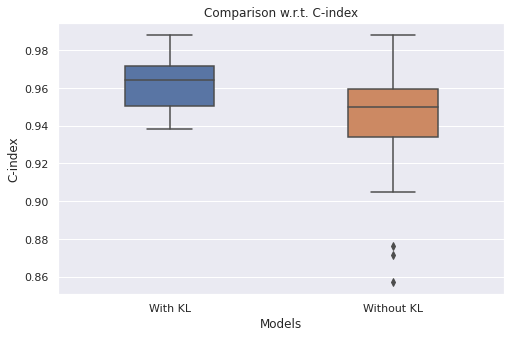

In [519]:
# fig = plt.figure(figsize =(10, 7))
import seaborn as sns
# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width / 2, men_means, width, label='Men')
# rects2 = ax.bar(x + width / 2, women_means, width, label='Women')
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# Creating plot
concordance_td_array = np.array(concordance_td_list)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list)
integrated_nbll_array = np.array(integrated_nbll_list)
integrated_nbll_array_old = np.array(integrated_nbll_list_old)
likelihood_array = np.array(likelihood_list)
likelihood_array_old = np.array(likelihood_list_old)

data = np.array(concordance_td_list + concordance_td_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Models": label})

sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x='Models', y='C-index', data=df, width = 0.4).set(title = "Comparison w.r.t. C-index")
len(data)
# plt.boxplot([concordance_td_array, concordance_td_array_old])
# plt.title("Comparison w.r.t. C-index")
# plt.ylabel("C-index")
# show plot
# plt.show()

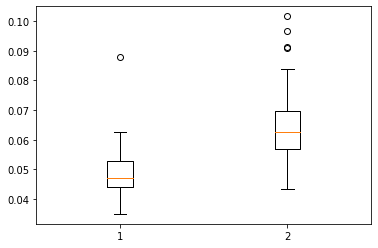

In [ ]:
plt.boxplot([integrated_brier_score_array, integrated_brier_score_array_old])
plt.show()

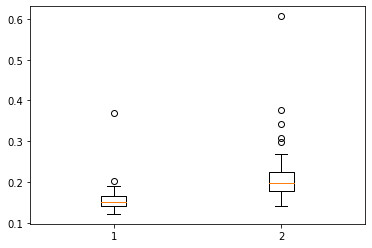

In [ ]:
plt.boxplot([integrated_nbll_array, integrated_nbll_array_old])
plt.show()

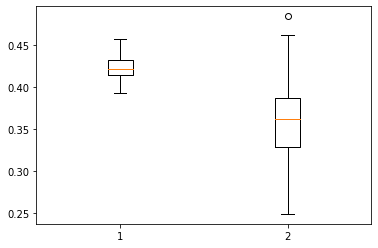

In [ ]:
plt.boxplot([likelihood_array, likelihood_array_old])
plt.show()

# Extension: Prior with deep learning?

In [ ]:
# Due to the starter number difference between Python and R
data_prior['time'] = data_prior['time'] - 1

In [ ]:
# Standardize for continuous data, remaining the same for categorical data

cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

data_prior_mapper = DataFrameMapper(standardize + leave)

In [ ]:
data_prior_test = data_prior.sample(frac=0.2)
data_prior_train = data_prior.drop(data_prior_test.index)
data_prior_val = data_prior_train.sample(frac=0.2)
data_prior_train = data_prior_train.drop(data_prior_val.index)

In [ ]:
data_prior_train

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time
3,0,0.503094,0.138824,-0.481668,-0.958850,-1.150178,1,1,1,0,1,6
4,0,-0.137754,1.030716,-0.069327,0.637014,0.618091,1,1,1,0,0,5
7,0,0.755846,0.482250,-0.088956,-1.495857,-1.826243,0,1,1,0,0,9
8,0,-0.094970,0.602343,1.076478,0.478586,1.512609,1,0,1,1,0,9
10,0,1.153147,0.926107,1.163974,0.893223,1.126522,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0,-0.692818,-0.392717,0.679147,1.170516,-0.060998,1,1,1,0,1,7
9995,0,-0.915949,-0.087417,0.033986,-0.848910,-0.534234,0,0,1,1,1,4
9996,0,-1.179707,-1.155198,-1.648140,0.384699,1.118215,0,1,1,0,1,2
9997,0,1.233159,-0.280681,0.073404,-1.476220,-0.040967,0,0,1,0,0,2


In [ ]:
data_prior_train_index = np.array(data_prior_train.index)
data_prior_val_index = np.array(data_prior_val.index)

In [ ]:
x_train = data_prior_mapper.fit_transform(data_prior_train).astype('float32')
x_val = data_prior_mapper.transform(data_prior_val).astype('float32')
x_test = data_prior_mapper.transform(data_prior_test).astype('float32')

In [ ]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['status'].values)

# CHANGE HERE!!!
y_train = labtrans.fit_transform(*get_target(data_prior_train))
y_val = labtrans.transform(*get_target(data_prior_val))
# n_train = data_local_train.shape[0]
# n_val = data_local_val.shape[0]
# y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
# y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)


train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(data_prior_test)

In [ ]:
labtrans.cuts

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [ ]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [ ]:
batch_size = 20
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [ ]:
y_train

# TODO: Fill in the data with the expanded version of data in the first line

(array([6, 5, 9, ..., 2, 2, 9]),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [ ]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.6588,	val_loss: 0.2911
1:	[1s / 2s],		train_loss: 0.3151,	val_loss: 0.2794
2:	[6s / 8s],		train_loss: 0.3078,	val_loss: 0.2825
3:	[5s / 13s],		train_loss: 0.3001,	val_loss: 0.2861
4:	[4s / 18s],		train_loss: 0.2911,	val_loss: 0.2872
5:	[1s / 20s],		train_loss: 0.2969,	val_loss: 0.2725
6:	[0s / 21s],		train_loss: 0.2951,	val_loss: 0.3027
7:	[0s / 21s],		train_loss: 0.2944,	val_loss: 0.2804
8:	[0s / 22s],		train_loss: 0.2854,	val_loss: 0.2757
9:	[0s / 23s],		train_loss: 0.2865,	val_loss: 0.2799
10:	[0s / 23s],		train_loss: 0.2794,	val_loss: 0.2677
11:	[0s / 24s],		train_loss: 0.2709,	val_loss: 0.2814
12:	[0s / 25s],		train_loss: 0.2753,	val_loss: 0.2752
13:	[0s / 26s],		train_loss: 0.2806,	val_loss: 0.2792
14:	[0s / 26s],		train_loss: 0.2720,	val_loss: 0.2829
15:	[0s / 27s],		train_loss: 0.2743,	val_loss: 0.2769
16:	[0s / 28s],		train_loss: 0.2679,	val_loss: 0.2828
17:	[0s / 28s],		train_loss: 0.2664,	val_loss: 0.2847
18:	[0s / 29s],		train_loss: 0.2659,	val_

In [ ]:
x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
x_val = data_local_mapper.transform(data_local_val).astype('float32')
x_test = data_local_mapper.transform(data_local_test).astype('float32')

In [ ]:
prior_info_train = model.predict_hazard(x_train)
prior_info_val = model.predict_hazard(x_val)

In [ ]:
prior_info.shape

(300, 10)

In [ ]:
data_local_train_index = np.array(data_local_train.index)
data_local_val_index = np.array(data_local_val.index)

In [ ]:
time = data_local["time"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 11))
np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
zeros = zeros[:, 1:]
zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
zeros_train = zeros[data_local_train_index]
zeros_val = zeros[data_local_val_index]

In [ ]:
eta = 10
combined_info_train = (zeros_train + eta * prior_info_train) / (1 + eta)
combined_info_val = (zeros_val + eta * prior_info_val) / (1 + eta)

In [ ]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['status'].values)

# CHANGE HERE!!!
# y_train = labtrans.fit_transform(*get_target(data_local_train))
# y_val = labtrans.transform(*get_target(data_local_val))
n_train = data_local_train.shape[0]
n_val = data_local_val.shape[0]
y_train = (combined_info_train, data_local_train['time'].values, data_local_train['status'].values)
y_val = (combined_info_val, data_local_val['time'].values, data_local_val['status'].values)


train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(data_local_test)

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [ ]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

1


In [ ]:
batch_size = 20
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [ ]:
y_train[0].shape

# TODO: Fill in the data with the expanded version of data in the first line

(192, 10)

In [ ]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 4.0784,	val_loss: 3.5575
1:	[0s / 0s],		train_loss: 3.1741,	val_loss: 2.5076
2:	[0s / 0s],		train_loss: 2.0175,	val_loss: 1.3588
3:	[0s / 0s],		train_loss: 1.0285,	val_loss: 0.6863
4:	[0s / 0s],		train_loss: 0.6025,	val_loss: 0.4635
5:	[0s / 0s],		train_loss: 0.4181,	val_loss: 0.3897
6:	[0s / 0s],		train_loss: 0.5380,	val_loss: 0.3548
7:	[0s / 0s],		train_loss: 0.3879,	val_loss: 0.3735
8:	[0s / 0s],		train_loss: 0.4217,	val_loss: 0.3615
9:	[0s / 0s],		train_loss: 0.3760,	val_loss: 0.3407
10:	[0s / 0s],		train_loss: 0.3578,	val_loss: 0.3322
11:	[0s / 0s],		train_loss: 0.3578,	val_loss: 0.3289
12:	[0s / 0s],		train_loss: 0.3855,	val_loss: 0.3255
13:	[0s / 0s],		train_loss: 0.3507,	val_loss: 0.3245
14:	[0s / 0s],		train_loss: 0.3578,	val_loss: 0.3151
15:	[0s / 0s],		train_loss: 0.3632,	val_loss: 0.3213
16:	[0s / 0s],		train_loss: 0.3476,	val_loss: 0.3243
17:	[0s / 0s],		train_loss: 0.3891,	val_loss: 0.3244
18:	[0s / 0s],		train_loss: 0.3557,	val_loss: 0.3306
19:

In [ ]:
concordance_td_list_prior_deep = []
integrated_brier_score_list_prior_deep = []
integrated_nbll_list_prior_deep = []
likelihood_list_prior_deep = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info_train, data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info_val, data_local_val['time'].values, data_local_val['status'].values)
  train = (x_train, y_train)
  val = (x_val, y_val)


  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list_prior_deep.append(ev.concordance_td('antolini'))
  integrated_brier_score_list_prior_deep.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_prior_deep.append(ev.integrated_nbll(time_grid))
  likelihood_list_prior_deep.append(log.to_pandas().val_loss.min())

1
0:	[0s / 0s],		train_loss: 4.0136,	val_loss: 3.5298
1:	[0s / 0s],		train_loss: 3.1304,	val_loss: 2.4920
2:	[0s / 0s],		train_loss: 1.9981,	val_loss: 1.3823
3:	[0s / 0s],		train_loss: 0.9923,	val_loss: 0.7168
4:	[0s / 0s],		train_loss: 0.5651,	val_loss: 0.5003
5:	[0s / 0s],		train_loss: 0.4321,	val_loss: 0.4312
6:	[0s / 0s],		train_loss: 0.3955,	val_loss: 0.4022
7:	[0s / 0s],		train_loss: 0.4010,	val_loss: 0.3914
8:	[0s / 0s],		train_loss: 0.3994,	val_loss: 0.3887
9:	[0s / 0s],		train_loss: 0.4195,	val_loss: 0.3777
10:	[0s / 0s],		train_loss: 0.3725,	val_loss: 0.3774
11:	[0s / 0s],		train_loss: 0.4088,	val_loss: 0.3993
12:	[0s / 0s],		train_loss: 0.3620,	val_loss: 0.4007
13:	[0s / 0s],		train_loss: 0.3766,	val_loss: 0.3872
14:	[0s / 0s],		train_loss: 0.3432,	val_loss: 0.3724
15:	[0s / 0s],		train_loss: 0.3807,	val_loss: 0.3845
16:	[0s / 0s],		train_loss: 0.3471,	val_loss: 0.3809
17:	[0s / 0s],		train_loss: 0.3777,	val_loss: 0.3610
18:	[0s / 0s],		train_loss: 0.3646,	val_loss: 0.3497
1

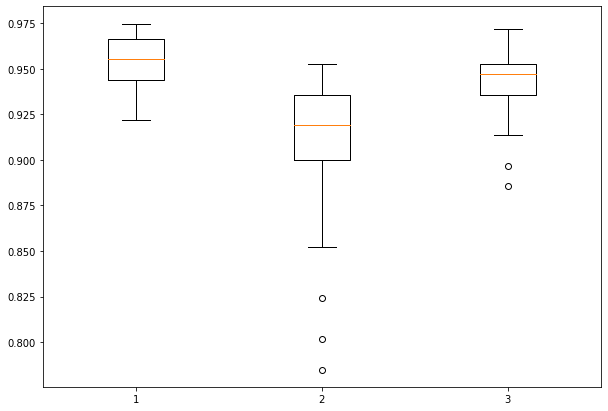

In [ ]:
fig = plt.figure(figsize =(10, 7))

# Creating plot
concordance_td_array = np.array(concordance_td_list)
concordance_td_array_old = np.array(concordance_td_list_old)
concordance_td_array_prior_deep = np.array(concordance_td_list_prior_deep)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list)
integrated_brier_score_array_prior_deep = np.array(integrated_brier_score_list_prior_deep)
integrated_nbll_array = np.array(integrated_nbll_list)
integrated_nbll_array_old = np.array(integrated_nbll_list_old)
integrated_nbll_array_prior_deep = np.array(integrated_brier_score_list_prior_deep)
likelihood_array = np.array(likelihood_list)
likelihood_array_old = np.array(likelihood_list_old)
likelihood_array_prior_deep = np.array(likelihood_list_prior_deep)

plt.boxplot([concordance_td_array, concordance_td_array_old, concordance_td_array_prior_deep])

# show plot
plt.show()

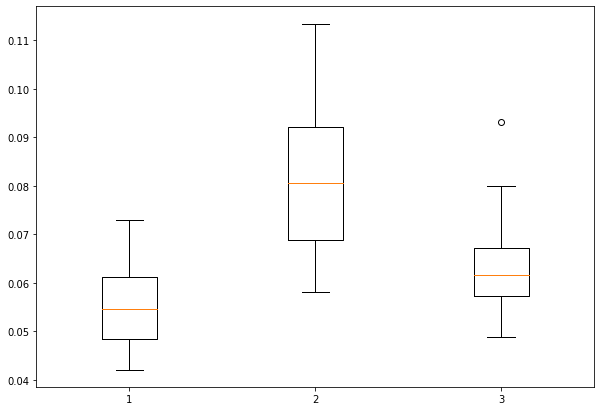

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot([integrated_brier_score_array, integrated_brier_score_array_old, integrated_brier_score_array_prior_deep])
plt.show()

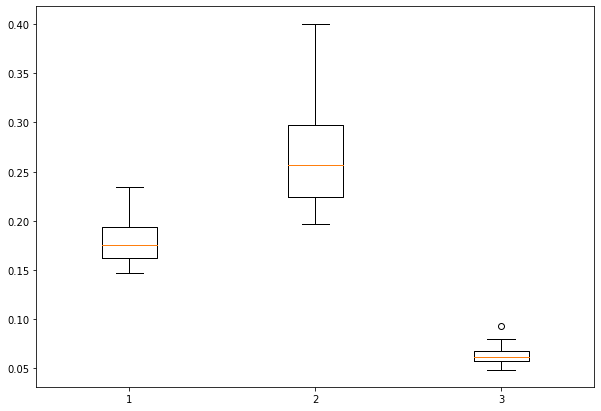

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot([integrated_nbll_array, integrated_nbll_array_old, integrated_nbll_array_prior_deep])
plt.show()

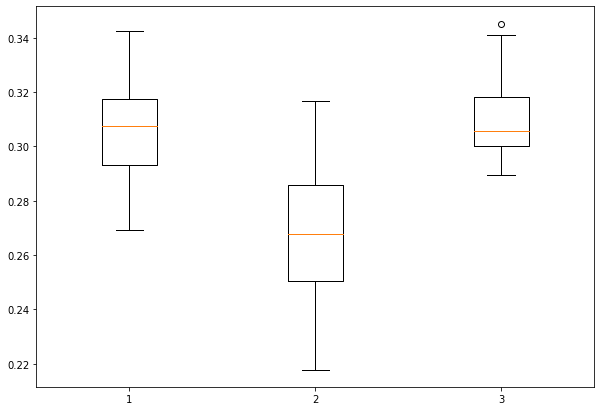

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot([likelihood_array, likelihood_array_old, likelihood_array_prior_deep])
plt.show()

# Cross Validation

## First Trial: 4 etas and compare using C-index and IBS

In [15]:
eta = 0
combined_info = (zeros + eta * prior_info) / (1 + eta)
combined_info

NameError: ignored

In [27]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")

In [28]:
# Due to the starter number difference between Python and R
data_local['time'] = data_local['time'] - 1

In [29]:
# Standardize for continuous data, remaining the same for categorical data

cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

data_local_mapper = DataFrameMapper(standardize + leave)

In [47]:
data_local

data_local_test = data_local.sample(frac=0.2)
data_local_train = data_local.drop(data_local_test.index)
data_local_val = data_local_train.sample(frac=0.2)
data_local_train = data_local_train.drop(data_local_val.index)

In [31]:
# # Devide training data into another "training, test, val" data.

# data_local_train_test = data_local_train.sample(frac=0.2)
# data_local_train_train = data_local_train.drop(data_local_train_test.index)
# data_local_train_val = data_local_train_train.sample(frac=0.2)
# data_local_train_train = data_local_train_train.drop(data_local_train_val.index)

# data_local_train_train

,Unnamed: 0,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time,LP_prior1
1,2,0,0.276078,-0.087196,0.264314,0.638372,-0.265806,0,1,0,1,0,5,-6.177399
2,3,0,0.057311,-1.433433,-1.697019,-0.457663,-0.901141,0,0,0,1,0,9,-1.676150
5,6,0,0.028990,1.346475,-0.117405,2.015577,2.009810,1,1,0,0,1,5,-4.460886
9,10,0,0.982519,0.167149,-0.778150,-2.169888,-1.620557,0,0,0,1,1,2,1.625827
12,13,1,-0.832449,-0.974342,-0.094613,-1.537500,-0.193979,1,1,0,1,1,3,-0.673131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,281,0,-1.969135,-0.160939,-0.579135,0.411742,0.320934,1,1,1,0,0,2,-1.968365
283,284,0,0.355362,0.637125,-0.446821,-0.231354,-1.010440,0,1,1,1,1,5,-4.361497
289,290,0,-2.024443,1.494408,-0.444799,0.828594,-0.303950,1,0,1,0,0,4,-3.281114
294,295,0,-0.823789,-1.429319,-0.449583,-1.025423,-1.065238,1,0,0,1,1,2,-3.758514


In [48]:
data_local_train_index = np.array(data_local_train.index)
data_local_val_index = np.array(data_local_val.index)

In [68]:
x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
x_val = data_local_mapper.transform(data_local_val).astype('float32')
x_test = data_local_mapper.transform(data_local_test).astype('float32')

In [59]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['status'].values)

# CHANGE HERE!!!
# y_train = labtrans.fit_transform(*get_target(data_local_train))
# y_val = labtrans.transform(*get_target(data_local_val))
n_train = data_local_train.shape[0]
n_val = data_local_val.shape[0]
y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)


train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(data_local_val)

In [60]:
labtrans.cuts

In [61]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [62]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

1


In [63]:
batch_size = 20
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [64]:
y_train[0].shape

(192, 10)

In [65]:
x_train.shape

(192, 10)

In [66]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 4.2852,	val_loss: 3.7301
1:	[0s / 0s],		train_loss: 3.3159,	val_loss: 2.9650
2:	[0s / 0s],		train_loss: 2.1001,	val_loss: 1.7764
3:	[0s / 0s],		train_loss: 1.0414,	val_loss: 0.8475
4:	[0s / 0s],		train_loss: 0.5020,	val_loss: 0.5471
5:	[0s / 0s],		train_loss: 0.3855,	val_loss: 0.4838
6:	[0s / 0s],		train_loss: 0.3035,	val_loss: 0.4453
7:	[0s / 0s],		train_loss: 0.3542,	val_loss: 0.4129
8:	[0s / 0s],		train_loss: 0.2656,	val_loss: 0.3987
9:	[0s / 0s],		train_loss: 0.2452,	val_loss: 0.3737
10:	[0s / 0s],		train_loss: 0.2197,	val_loss: 0.3572
11:	[0s / 0s],		train_loss: 0.2348,	val_loss: 0.3895
12:	[0s / 0s],		train_loss: 0.1923,	val_loss: 0.4049
13:	[0s / 0s],		train_loss: 0.1719,	val_loss: 0.3973
14:	[0s / 0s],		train_loss: 0.1931,	val_loss: 0.4656
15:	[0s / 0s],		train_loss: 0.1570,	val_loss: 0.4606
16:	[0s / 0s],		train_loss: 0.1887,	val_loss: 0.4194
17:	[0s / 0s],		train_loss: 0.1521,	val_loss: 0.4326
18:	[0s / 0s],		train_loss: 0.1723,	val_loss: 0.4695
19:

In [111]:
surv = model.predict_surv_df(x_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td('antolini')

0.8811881188118812

In [70]:
concordance_td_list_1 = []
integrated_brier_score_list_1 = []
integrated_nbll_list_1 = []
likelihood_list_1 = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  train = (x_train, y_train)
  val = (x_val, y_val)

  durations_test, events_test = get_target(data_local_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  # durations_test, events_test = get_target(data_local_train_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  surv = model.predict_surv_df(x_val)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list_1.append(ev.concordance_td('antolini'))
  integrated_brier_score_list_1.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_1.append(ev.integrated_nbll(time_grid))
  likelihood_list_1.append(log.to_pandas().val_loss.min())

1
0:	[0s / 0s],		train_loss: 4.2919,	val_loss: 3.5402
1:	[0s / 0s],		train_loss: 3.4100,	val_loss: 2.8002
2:	[0s / 0s],		train_loss: 2.2627,	val_loss: 1.6643
3:	[0s / 0s],		train_loss: 1.1725,	val_loss: 0.9058
4:	[0s / 0s],		train_loss: 0.5819,	val_loss: 0.6134
5:	[0s / 0s],		train_loss: 0.3877,	val_loss: 0.5211
6:	[0s / 0s],		train_loss: 0.3464,	val_loss: 0.4908
7:	[0s / 0s],		train_loss: 0.3112,	val_loss: 0.4620
8:	[0s / 0s],		train_loss: 0.2607,	val_loss: 0.4673
9:	[0s / 0s],		train_loss: 0.2037,	val_loss: 0.4933
10:	[0s / 0s],		train_loss: 0.2373,	val_loss: 0.5111
11:	[0s / 0s],		train_loss: 0.2933,	val_loss: 0.5281
12:	[0s / 0s],		train_loss: 0.2114,	val_loss: 0.5134
13:	[0s / 0s],		train_loss: 0.1822,	val_loss: 0.5073
14:	[0s / 0s],		train_loss: 0.1732,	val_loss: 0.5009
15:	[0s / 0s],		train_loss: 0.1878,	val_loss: 0.5329
16:	[0s / 0s],		train_loss: 0.1602,	val_loss: 0.5763
17:	[0s / 0s],		train_loss: 0.1702,	val_loss: 0.6055


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


1
0:	[0s / 0s],		train_loss: 4.1280,	val_loss: 3.6330
1:	[0s / 0s],		train_loss: 3.2969,	val_loss: 2.6103
2:	[0s / 0s],		train_loss: 2.1075,	val_loss: 1.5038
3:	[0s / 0s],		train_loss: 1.0889,	val_loss: 0.7512
4:	[0s / 0s],		train_loss: 0.5311,	val_loss: 0.5115
5:	[0s / 0s],		train_loss: 0.3309,	val_loss: 0.4591
6:	[0s / 0s],		train_loss: 0.3392,	val_loss: 0.4555
7:	[0s / 0s],		train_loss: 0.2840,	val_loss: 0.4111
8:	[0s / 0s],		train_loss: 0.2833,	val_loss: 0.3832
9:	[0s / 0s],		train_loss: 0.1909,	val_loss: 0.4084
10:	[0s / 0s],		train_loss: 0.1962,	val_loss: 0.4447
11:	[0s / 0s],		train_loss: 0.1877,	val_loss: 0.4513
12:	[0s / 0s],		train_loss: 0.2199,	val_loss: 0.4576
13:	[0s / 0s],		train_loss: 0.2273,	val_loss: 0.4681
14:	[0s / 0s],		train_loss: 0.1771,	val_loss: 0.4590
15:	[0s / 0s],		train_loss: 0.1435,	val_loss: 0.4097
16:	[0s / 0s],		train_loss: 0.1830,	val_loss: 0.4208
17:	[0s / 0s],		train_loss: 0.2285,	val_loss: 0.4945
18:	[0s / 0s],		train_loss: 0.1612,	val_loss: 0.4964
1

In [71]:
eta = 0.3
combined_info = (zeros + eta * prior_info) / (1 + eta)
combined_info

array([[1.08293939e-04, 8.42279553e-05, 1.09893474e-04, ...,
        1.21825442e-03, 4.07441572e-03, 3.51332768e-03],
       [1.38959407e-06, 1.08067556e-06, 1.41012845e-06, ...,
        1.57068739e-05, 5.31843820e-05, 4.57486040e-05],
       [1.24245084e-04, 9.66357889e-05, 1.26080094e-04, ...,
        1.39670711e-03, 4.66274716e-03, 4.02207742e-03],
       ...,
       [5.39522943e-10, 4.19581871e-10, 5.47495660e-10, ...,
        6.09871951e-09, 2.06539696e-08, 1.77657387e-08],
       [2.45674789e-03, 1.91512201e-03, 2.49265997e-03, ...,
        2.50256816e-02, 6.73269567e-02, 6.03752118e-02],
       [2.26177745e-03, 1.76280376e-03, 2.29486815e-03, ...,
        2.32217872e-02, 6.34137136e-02, 5.67257893e-02]])

In [72]:
concordance_td_list_2 = []
integrated_brier_score_list_2 = []
integrated_nbll_list_2 = []
likelihood_list_2 = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  train = (x_train, y_train)
  val = (x_val, y_val)

  durations_test, events_test = get_target(data_local_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  # durations_test, events_test = get_target(data_local_train_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  surv = model.predict_surv_df(x_val)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list_2.append(ev.concordance_td('antolini'))
  integrated_brier_score_list_2.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_2.append(ev.integrated_nbll(time_grid))
  likelihood_list_2.append(log.to_pandas().val_loss.min())

1
0:	[0s / 0s],		train_loss: 4.2170,	val_loss: 3.8592
1:	[0s / 0s],		train_loss: 3.2543,	val_loss: 2.6616
2:	[0s / 0s],		train_loss: 2.1424,	val_loss: 1.3826
3:	[0s / 0s],		train_loss: 1.0028,	val_loss: 0.7243
4:	[0s / 0s],		train_loss: 0.5828,	val_loss: 0.4910
5:	[0s / 0s],		train_loss: 0.4106,	val_loss: 0.4058
6:	[0s / 0s],		train_loss: 0.3227,	val_loss: 0.3743
7:	[0s / 0s],		train_loss: 0.3549,	val_loss: 0.3832
8:	[0s / 0s],		train_loss: 0.3530,	val_loss: 0.3850
9:	[0s / 0s],		train_loss: 0.3278,	val_loss: 0.3848
10:	[0s / 0s],		train_loss: 0.2698,	val_loss: 0.3707
11:	[0s / 0s],		train_loss: 0.2855,	val_loss: 0.3742
12:	[0s / 0s],		train_loss: 0.2468,	val_loss: 0.3772
13:	[0s / 0s],		train_loss: 0.2545,	val_loss: 0.4081
14:	[0s / 0s],		train_loss: 0.2298,	val_loss: 0.4027
15:	[0s / 0s],		train_loss: 0.2540,	val_loss: 0.4011
16:	[0s / 0s],		train_loss: 0.2582,	val_loss: 0.4491
17:	[0s / 0s],		train_loss: 0.2308,	val_loss: 0.4118
18:	[0s / 0s],		train_loss: 0.2007,	val_loss: 0.3944
1

In [129]:
eta = 1
combined_info = (zeros + eta * prior_info) / (1 + eta)
combined_info

array([[2.34636868e-04, 1.82493903e-04, 2.38102527e-04, ...,
        2.63955125e-03, 8.82790072e-03, 7.61220997e-03],
       [3.01078714e-06, 2.34146371e-06, 3.05527831e-06, ...,
        3.40315602e-05, 1.15232828e-04, 9.91219753e-05],
       [2.69197682e-04, 2.09377543e-04, 2.73173536e-04, ...,
        3.02619873e-03, 1.01026188e-02, 8.71450108e-03],
       ...,
       [1.16896638e-09, 9.09094055e-10, 1.18624060e-09, ...,
        1.32138923e-08, 4.47502674e-08, 3.84924339e-08],
       [5.32295377e-03, 4.14943102e-03, 5.40076326e-03, ...,
        5.42223102e-02, 1.45875073e-01, 1.30812959e-01],
       [4.90051782e-03, 3.81940815e-03, 4.97221432e-03, ...,
        5.03138723e-02, 1.37396380e-01, 1.22905877e-01]])

In [73]:
concordance_td_list_3 = []
integrated_brier_score_list_3 = []
integrated_nbll_list_3 = []
likelihood_list_3 = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  train = (x_train, y_train)
  val = (x_val, y_val)

  durations_test, events_test = get_target(data_local_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  # durations_test, events_test = get_target(data_local_train_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  surv = model.predict_surv_df(x_val)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list_3.append(ev.concordance_td('antolini'))
  integrated_brier_score_list_3.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_3.append(ev.integrated_nbll(time_grid))
  likelihood_list_3.append(log.to_pandas().val_loss.min())

1
0:	[0s / 0s],		train_loss: 4.1250,	val_loss: 3.4394
1:	[0s / 0s],		train_loss: 3.2570,	val_loss: 2.7026
2:	[0s / 0s],		train_loss: 2.1219,	val_loss: 1.4445
3:	[0s / 0s],		train_loss: 1.0746,	val_loss: 0.6831
4:	[0s / 0s],		train_loss: 0.5644,	val_loss: 0.4728
5:	[0s / 0s],		train_loss: 0.3715,	val_loss: 0.4161
6:	[0s / 0s],		train_loss: 0.3588,	val_loss: 0.4050
7:	[0s / 0s],		train_loss: 0.3030,	val_loss: 0.4126
8:	[0s / 0s],		train_loss: 0.3121,	val_loss: 0.3825
9:	[0s / 0s],		train_loss: 0.3526,	val_loss: 0.3863
10:	[0s / 0s],		train_loss: 0.2807,	val_loss: 0.3971
11:	[0s / 0s],		train_loss: 0.2742,	val_loss: 0.3766
12:	[0s / 0s],		train_loss: 0.2776,	val_loss: 0.3868
13:	[0s / 1s],		train_loss: 0.2644,	val_loss: 0.3968
14:	[0s / 1s],		train_loss: 0.2448,	val_loss: 0.4085
15:	[0s / 1s],		train_loss: 0.2254,	val_loss: 0.4075
16:	[0s / 1s],		train_loss: 0.2460,	val_loss: 0.3644
17:	[0s / 1s],		train_loss: 0.2298,	val_loss: 0.3893
18:	[0s / 1s],		train_loss: 0.2279,	val_loss: 0.4239
1

In [76]:
eta = 10
combined_info = (zeros + eta * prior_info) / (1 + eta)
combined_info

array([[4.26612487e-04, 3.31807097e-04, 4.32913685e-04, ...,
        4.79918408e-03, 1.60507286e-02, 1.38403818e-02],
       [5.47415844e-06, 4.25720675e-06, 5.55505148e-06, ...,
        6.18755640e-05, 2.09514232e-04, 1.80221773e-04],
       [4.89450332e-04, 3.80686441e-04, 4.96679157e-04, ...,
        5.50217951e-03, 1.83683979e-02, 1.58445474e-02],
       ...,
       [2.12539341e-09, 1.65289828e-09, 2.15680109e-09, ...,
        2.40252587e-08, 8.13641225e-08, 6.99862434e-08],
       [9.67809776e-03, 7.54442003e-03, 9.81956956e-03, ...,
        9.85860186e-02, 2.65227405e-01, 2.37841743e-01],
       [8.91003239e-03, 6.94437846e-03, 9.04038967e-03, ...,
        9.14797679e-02, 2.49811599e-01, 2.23465231e-01]])

In [77]:
concordance_td_list_4 = []
integrated_brier_score_list_4 = []
integrated_nbll_list_4 = []
likelihood_list_4 = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  train = (x_train, y_train)
  val = (x_val, y_val)

  durations_test, events_test = get_target(data_local_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  # durations_test, events_test = get_target(data_local_train_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  surv = model.predict_surv_df(x_val)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list_4.append(ev.concordance_td('antolini'))
  integrated_brier_score_list_4.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_4.append(ev.integrated_nbll(time_grid))
  likelihood_list_4.append(log.to_pandas().val_loss.min())

1
0:	[0s / 0s],		train_loss: 4.2030,	val_loss: 3.6671
1:	[0s / 1s],		train_loss: 3.3438,	val_loss: 2.5313
2:	[0s / 1s],		train_loss: 2.1150,	val_loss: 1.3395
3:	[0s / 2s],		train_loss: 1.0500,	val_loss: 0.6399
4:	[0s / 2s],		train_loss: 0.5858,	val_loss: 0.4167
5:	[0s / 2s],		train_loss: 0.4528,	val_loss: 0.3516
6:	[0s / 2s],		train_loss: 0.4142,	val_loss: 0.3177
7:	[0s / 2s],		train_loss: 0.3825,	val_loss: 0.2995
8:	[0s / 2s],		train_loss: 0.3945,	val_loss: 0.2869
9:	[0s / 2s],		train_loss: 0.3468,	val_loss: 0.2821
10:	[0s / 3s],		train_loss: 0.3610,	val_loss: 0.2709
11:	[0s / 3s],		train_loss: 0.3548,	val_loss: 0.2708
12:	[0s / 3s],		train_loss: 0.3452,	val_loss: 0.2701
13:	[0s / 3s],		train_loss: 0.3422,	val_loss: 0.2550
14:	[0s / 3s],		train_loss: 0.3433,	val_loss: 0.2675
15:	[0s / 3s],		train_loss: 0.3785,	val_loss: 0.2666
16:	[0s / 3s],		train_loss: 0.3454,	val_loss: 0.2397
17:	[0s / 3s],		train_loss: 0.3390,	val_loss: 0.2813
18:	[0s / 3s],		train_loss: 0.3489,	val_loss: 0.2733
1

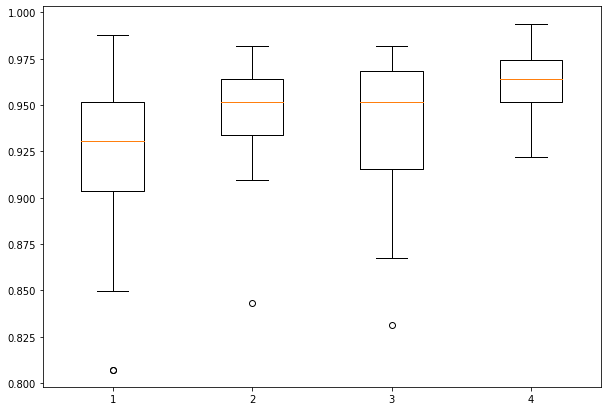

In [80]:
fig = plt.figure(figsize =(10, 7))

# Creating plot
concordance_td_array_1 = np.array(concordance_td_list_1)
concordance_td_array_2 = np.array(concordance_td_list_2)
concordance_td_array_3 = np.array(concordance_td_list_3)
concordance_td_array_4 = np.array(concordance_td_list_4)
integrated_brier_score_array_1 = np.array(integrated_brier_score_list_1)
integrated_brier_score_array_2 = np.array(integrated_brier_score_list_2)
integrated_brier_score_array_3 = np.array(integrated_brier_score_list_3)
integrated_brier_score_array_4 = np.array(integrated_brier_score_list_4)

# integrated_nbll_array = np.array(integrated_nbll_list)
# integrated_nbll_array_old = np.array(integrated_nbll_list_old)
# integrated_nbll_array_prior_deep = np.array(integrated_brier_score_list_prior_deep)
# likelihood_array = np.array(likelihood_list)
# likelihood_array_old = np.array(likelihood_list_old)
# likelihood_array_prior_deep = np.array(likelihood_list_prior_deep)

plt.boxplot([concordance_td_array_1, concordance_td_array_2, concordance_td_array_3, concordance_td_array_4])

# show plot
plt.show()

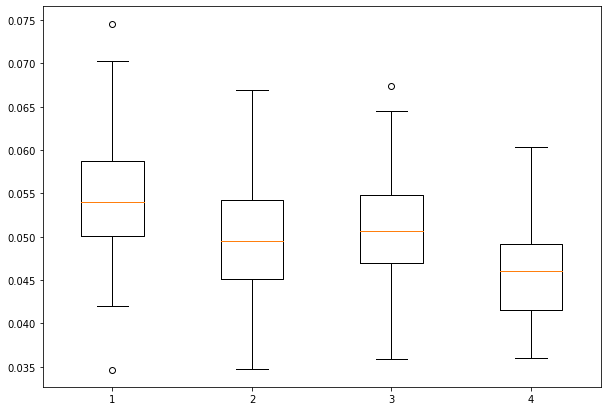

In [82]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot([integrated_brier_score_array_1, integrated_brier_score_array_2, integrated_brier_score_array_3, integrated_brier_score_array_4])
plt.show()

## Cross Validation

In [74]:
from sklearn.model_selection import KFold # import KFold

In [93]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")

In [94]:
# Due to the starter number difference between Python and R
data_local['time'] = data_local['time'] - 1

In [95]:
# Standardize for continuous data, remaining the same for categorical data

cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

data_local_mapper = DataFrameMapper(standardize + leave)

In [108]:
# CHANGE HERE!

data_local_test = data_local.sample(frac=0.2)
data_local_train = data_local.drop(data_local_test.index)
# data_local_val = data_local_train.sample(frac=0.2)
# data_local_train = data_local_train.drop(data_local_val.index)
data_local = data_local_train.copy()

In [109]:
# # Devide training data into another "training, test, val" data.

# data_local_train_test = data_local_train.sample(frac=0.2)
# data_local_train_train = data_local_train.drop(data_local_train_test.index)
# data_local_train_val = data_local_train_train.sample(frac=0.2)
# data_local_train_train = data_local_train_train.drop(data_local_train_val.index)

# data_local_train_train

In [110]:
data_local_index = np.array(data_local.index)
# data_local_val_index = np.array(data_local_val.index)
combined_info_train = combined_info[data_local_index]

In [111]:
combined_info_train.shape

(192, 10)

In [113]:
x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
# x_val = data_local_mapper.transform(data_local_val).astype('float32')
x_test = data_local_mapper.transform(data_local_test).astype('float32')
X_train = x_train.copy()

In [122]:
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(X_train) # returns the number of splitting iterations in the cross-validator

5

In [128]:
eta_list = [i / 4 for i in range(40)]

best_eta = 0
best_concordance = 0
concordance_td_list = []
for eta in eta_list:
  concordance_td_list_CV = []
  integrated_brier_score_list_CV = []
  integrated_nbll_list_CV = []
  likelihood_list_CV = []

  combined_info = (zeros + eta * prior_info) / (1 + eta)

  data_local_index = np.array(data_local.index)
  combined_info_train = combined_info[data_local_index]

  for train_index, test_index in kf.split(X_train):
    data_local_train_index = train_index
    data_local_val_index = test_index
    data_local_train = data_local.iloc[data_local_train_index,]
    data_local_val = data_local.iloc[data_local_val_index,]
    x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
    x_val = data_local_mapper.transform(data_local_val).astype('float32')
    n_train = data_local_train.shape[0]
    n_val = data_local_val.shape[0]
    y_train = (combined_info_train[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
    y_val = (combined_info_train[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)

    train = (x_train, y_train)
    val = (x_val, y_val)
    labtrans = LogisticHazard.label_transform(num_durations)

    get_target = lambda df: (df['time'].values, df['status'].values)

    batch_size = 20
    epochs = 100
    callbacks = [tt.cb.EarlyStopping()]

    durations_test, events_test = get_target(data_local_val)

    num_durations = 10
    in_features = x_train.shape[1]
    num_nodes = [32, 32]
    out_features = num_durations
    batch_norm = True
    dropout = 0.1

    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

    # We don't need to transform the test labels
    # durations_test, events_test = get_target(data_local_train_test)

    model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

    log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
    surv = model.predict_surv_df(x_val)
    ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
    concordance_td_list_CV.append(ev.concordance_td('antolini'))
    integrated_brier_score_list_CV.append(ev.integrated_brier_score(time_grid))
    integrated_nbll_list_CV.append(ev.integrated_nbll(time_grid))
    likelihood_list_CV.append(log.to_pandas().val_loss.min())
  
  concordance_td = sum(concordance_td_list_CV) / len(concordance_td_list_CV)
  concordance_td_list.append(concordance_td)
  if(best_concordance < concordance_td):
    best_concordance = concordance_td
    best_eta = eta

best_eta


流式输出内容被截断，只能显示最后 5000 行内容。
20:	[0s / 0s],		train_loss: 0.4276,	val_loss: 0.3213
21:	[0s / 0s],		train_loss: 0.4154,	val_loss: 0.3198
22:	[0s / 0s],		train_loss: 0.3973,	val_loss: 0.3146
23:	[0s / 0s],		train_loss: 0.3719,	val_loss: 0.3193
24:	[0s / 0s],		train_loss: 0.3836,	val_loss: 0.3188
25:	[0s / 0s],		train_loss: 0.3898,	val_loss: 0.3057
26:	[0s / 0s],		train_loss: 0.4106,	val_loss: 0.3076
1
0:	[0s / 0s],		train_loss: 4.2689,	val_loss: 3.8878
1:	[0s / 0s],		train_loss: 3.4595,	val_loss: 3.3054
2:	[0s / 0s],		train_loss: 2.6011,	val_loss: 2.3824
3:	[0s / 0s],		train_loss: 1.7105,	val_loss: 1.4525
4:	[0s / 0s],		train_loss: 0.9691,	val_loss: 0.8950
5:	[0s / 0s],		train_loss: 0.6732,	val_loss: 0.6390
6:	[0s / 0s],		train_loss: 0.5251,	val_loss: 0.4988
7:	[0s / 0s],		train_loss: 0.4551,	val_loss: 0.4319
8:	[0s / 0s],		train_loss: 0.4448,	val_loss: 0.3997
9:	[0s / 0s],		train_loss: 0.4266,	val_loss: 0.3904
10:	[0s / 0s],		train_loss: 0.4201,	val_loss: 0.3902
11:	[0s / 0s],		train_loss:

9.5

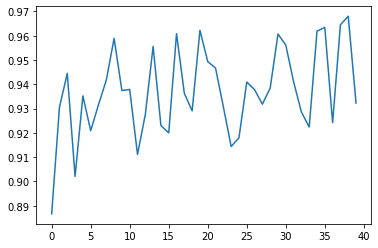

In [129]:
plt.plot(concordance_td_list)

In [102]:
x_train.shape

(192, 10)

In [73]:
data_local.shape

(154, 14)

In [ ]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['status'].values)

# CHANGE HERE!!!
# y_train = labtrans.fit_transform(*get_target(data_local_train))
# y_val = labtrans.transform(*get_target(data_local_val))


train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(data_local_val)

# Other Simulations

## With much smaller subset of covariates

In [14]:
data_prior = pd.read_csv("/content/drive/My Drive/Kevin He/prior_data_subset.csv")

In [15]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")

In [16]:
data_prior

,Unnamed: 0,status,Z1,Z2,Z6,Z7,time
0,1,0,-0.286215,0.139929,0,1,10
1,2,0,-1.020084,0.497558,1,1,10
2,3,0,-0.657176,-0.788317,1,0,2
3,4,0,1.062820,1.694089,0,0,10
4,5,0,1.519426,1.334383,1,0,8
...,...,...,...,...,...,...,...
9995,9996,0,0.076944,0.584749,1,0,3
9996,9997,0,-0.197012,-1.493841,1,0,5
9997,9998,0,0.191691,-0.470902,1,0,9
9998,9999,0,0.950740,0.634772,1,1,2


In [17]:
data_prior = data_prior.drop(['Unnamed: 0'], axis = 1)

In [25]:
data_prior_expanded = dataLong(data_prior)

In [26]:
data_prior_expanded

,status,Z1,Z2,Z6,Z7,time,y,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,0.0,-0.286215,0.139929,0.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.286215,0.139929,0.0,1.0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.286215,0.139929,0.0,1.0,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.286215,0.139929,0.0,1.0,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-0.286215,0.139929,0.0,1.0,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59911,0.0,-0.396628,-1.731480,1.0,0.0,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
59912,0.0,-0.396628,-1.731480,1.0,0.0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
59913,0.0,-0.396628,-1.731480,1.0,0.0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
59914,0.0,-0.396628,-1.731480,1.0,0.0,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [27]:
columns = ["Z1", "Z2", "Z6", "Z7"] + ['time' + str(i + 1) for i in range(10)]
# X = np.array(data_prior[columns])
# y = np.array(data_prior['y'])
X = data_prior_expanded[columns]
y = data_prior_expanded["y"]

In [28]:
import statsmodels.api as sm

# train_x['intercept'] = 1.0
logit = sm.Logit(y, X)
result = logit.fit(maxiter = 10000)
result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.079739
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                59916
Model:                          Logit   Df Residuals:                    59902
Method:                           MLE   Df Model:                           13
Date:                Tue, 12 Apr 2022   Pseudo R-squ.:                  0.1242
Time:                        16:22:38   Log-Likelihood:                -4777.6
converged:                       True   LL-Null:                       -5455.4
Covariance Type:            nonrobust   LLR p-value:                6.048e-282
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Z1            -0.6939      0.037    -18.605      0.000      -0.767      -0.621
Z2            -0.2153      0.037     -5.897      0.000      -0.287      -0.144
Z6            -1.4374      0.074    -19.441      0.000      -1.582      -1.292
Z7             0.4111      0.063      6.531      0.000       0.288       0.534
time1         -3.4174      0.074    -46.240      0.000      -3.562      -3.273
time2         -4.2705      0.100    -42.699      0.000      -4.466      -4.074
time3         -4.7573      0.128    -37.059      0.000      -5.009      -4.506
time4         -3.7999      0.093    -40.713      0.000      -3.983      -3.617
time5         -4.2432      0.119    -35.697      0.000      -4.476      -4.010
time6         -4.4199      0.139    -31.733      0.000      -4.693      -4.147
time7         -3.5523      0.108    -32.897      0.000      -3.764      -3.341
time8         -3.8940      0.139    -27.953      0.000      -4.167      -3.621
time9         -3.2567      0.124    -26.214      0.000      -3.500      -3.013
time10        -4.3625      0.250    -17.443      0.000      -4.853      -3.872
==============================================================================
"""

In [29]:
time_column = ["time" + str(i + 1) for i in range(10)]
cova_column = ["Z1", "Z2", "Z6", "Z7"]

beta_time = np.array(result.params[time_column])
beta_cova = np.array(result.params[cova_column])

In [30]:
Z = np.array(data_local[cova_column])
Z.shape

(300, 4)

In [31]:
prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

In [32]:
time = data_local["time"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 11))
np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
zeros = zeros[:, 1:]
zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
eta = 10
combined_info = (zeros + eta * prior_info) / (1 + eta)
combined_info

array([[0.00443836, 0.00189656, 0.00116647, ..., 0.00276101, 0.00520758,
        0.00173016],
       [0.03632702, 0.01584276, 0.00980199, ..., 0.02290343, 0.04236415,
        0.01447227],
       [0.03740571, 0.01632457, 0.01010217, ..., 0.0235943 , 0.04361315,
        0.0149131 ],
       ...,
       [0.00376808, 0.00160946, 0.00098977, ..., 0.00234339, 0.00442171,
        0.00146821],
       [0.00662768, 0.00283601, 0.00174497, ..., 0.00412672, 0.00777309,
        0.00258742],
       [0.01508935, 0.00649162, 0.00400043, ..., 0.00942874, 0.01766848,
        0.00592469]])

In [34]:
combined_info.shape

(300, 10)

### Cross Validation

In [50]:
from sklearn.model_selection import KFold # import KFold

In [51]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")

In [52]:
# Due to the starter number difference between Python and R
data_local['time'] = data_local['time'] - 1

In [53]:
# Standardize for continuous data, remaining the same for categorical data

cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

data_local_mapper = DataFrameMapper(standardize + leave)

In [54]:
# CHANGE HERE!

data_local_test = data_local.sample(frac=0.2)
data_local_train = data_local.drop(data_local_test.index)
# data_local_val = data_local_train.sample(frac=0.2)
# data_local_train = data_local_train.drop(data_local_val.index)
data_local = data_local_train.copy()

In [55]:
# # Devide training data into another "training, test, val" data.

# data_local_train_test = data_local_train.sample(frac=0.2)
# data_local_train_train = data_local_train.drop(data_local_train_test.index)
# data_local_train_val = data_local_train_train.sample(frac=0.2)
# data_local_train_train = data_local_train_train.drop(data_local_train_val.index)

# data_local_train_train

In [56]:
data_local_index = np.array(data_local.index)
# data_local_val_index = np.array(data_local_val.index)
combined_info_train = combined_info[data_local_index]

In [57]:
combined_info_train.shape

(240, 10)

In [58]:
x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
# x_val = data_local_mapper.transform(data_local_val).astype('float32')
x_test = data_local_mapper.transform(data_local_test).astype('float32')
X_train = x_train.copy()

In [59]:
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(X_train) # returns the number of splitting iterations in the cross-validator

5

In [60]:
eta_list = [i / 4 for i in range(40)]

best_eta = 0
best_concordance = 0
concordance_td_list = []
for eta in eta_list:
  concordance_td_list_CV = []
  integrated_brier_score_list_CV = []
  integrated_nbll_list_CV = []
  likelihood_list_CV = []

  combined_info = (zeros + eta * prior_info) / (1 + eta)

  data_local_index = np.array(data_local.index)
  combined_info_train = combined_info[data_local_index]

  for train_index, test_index in kf.split(X_train):
    data_local_train_index = train_index
    data_local_val_index = test_index
    data_local_train = data_local.iloc[data_local_train_index,]
    data_local_val = data_local.iloc[data_local_val_index,]
    x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
    x_val = data_local_mapper.transform(data_local_val).astype('float32')
    n_train = data_local_train.shape[0]
    n_val = data_local_val.shape[0]
    y_train = (combined_info_train[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
    y_val = (combined_info_train[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)

    train = (x_train, y_train)
    val = (x_val, y_val)
    labtrans = LogisticHazard.label_transform(num_durations)

    get_target = lambda df: (df['time'].values, df['status'].values)

    batch_size = 20
    epochs = 100
    callbacks = [tt.cb.EarlyStopping()]

    durations_test, events_test = get_target(data_local_val)

    num_durations = 10
    in_features = x_train.shape[1]
    num_nodes = [32, 32]
    out_features = num_durations
    batch_norm = True
    dropout = 0.1

    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

    # We don't need to transform the test labels
    # durations_test, events_test = get_target(data_local_train_test)

    model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

    log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
    surv = model.predict_surv_df(x_val)
    ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
    concordance_td_list_CV.append(ev.concordance_td('antolini'))
    integrated_brier_score_list_CV.append(ev.integrated_brier_score(time_grid))
    integrated_nbll_list_CV.append(ev.integrated_nbll(time_grid))
    likelihood_list_CV.append(log.to_pandas().val_loss.min())
  
  concordance_td = sum(concordance_td_list_CV) / len(concordance_td_list_CV)
  concordance_td_list.append(concordance_td)
  if(best_concordance < concordance_td):
    best_concordance = concordance_td
    best_eta = eta

best_eta


1
0:	[0s / 0s],		train_loss: 4.0248,	val_loss: 3.9082
1:	[0s / 0s],		train_loss: 3.1399,	val_loss: 2.8820
2:	[0s / 0s],		train_loss: 2.1053,	val_loss: 1.8320
3:	[0s / 0s],		train_loss: 1.0621,	val_loss: 0.8636
4:	[0s / 0s],		train_loss: 0.5845,	val_loss: 0.4891
5:	[0s / 0s],		train_loss: 0.4318,	val_loss: 0.3788
6:	[0s / 0s],		train_loss: 0.3459,	val_loss: 0.3386
7:	[0s / 0s],		train_loss: 0.3331,	val_loss: 0.3583
8:	[0s / 0s],		train_loss: 0.2642,	val_loss: 0.3379
9:	[0s / 0s],		train_loss: 0.2698,	val_loss: 0.3379
10:	[0s / 0s],		train_loss: 0.2905,	val_loss: 0.3347
11:	[0s / 0s],		train_loss: 0.2505,	val_loss: 0.3742
12:	[0s / 0s],		train_loss: 0.2158,	val_loss: 0.3482
13:	[0s / 0s],		train_loss: 0.2091,	val_loss: 0.3547
14:	[0s / 0s],		train_loss: 0.2296,	val_loss: 0.3805
15:	[0s / 0s],		train_loss: 0.2441,	val_loss: 0.3222
16:	[0s / 0s],		train_loss: 0.2216,	val_loss: 0.3491
17:	[0s / 0s],		train_loss: 0.2298,	val_loss: 0.3515
18:	[0s / 0s],		train_loss: 0.1660,	val_loss: 0.3309
1

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


流式输出内容被截断，只能显示最后 5000 行内容。
10:	[0s / 0s],		train_loss: 0.4736,	val_loss: 0.4531
11:	[0s / 0s],		train_loss: 0.4681,	val_loss: 0.4503
12:	[0s / 0s],		train_loss: 0.4698,	val_loss: 0.4531
13:	[0s / 0s],		train_loss: 0.4755,	val_loss: 0.4530
14:	[0s / 0s],		train_loss: 0.4605,	val_loss: 0.4494
15:	[0s / 0s],		train_loss: 0.4766,	val_loss: 0.4538
16:	[0s / 0s],		train_loss: 0.4541,	val_loss: 0.4542
17:	[0s / 0s],		train_loss: 0.4646,	val_loss: 0.4530
18:	[0s / 0s],		train_loss: 0.4624,	val_loss: 0.4538
19:	[0s / 0s],		train_loss: 0.4831,	val_loss: 0.4579
20:	[0s / 0s],		train_loss: 0.4634,	val_loss: 0.4528
21:	[0s / 0s],		train_loss: 0.4744,	val_loss: 0.4531
22:	[0s / 0s],		train_loss: 0.4594,	val_loss: 0.4557
23:	[0s / 0s],		train_loss: 0.4691,	val_loss: 0.4557
24:	[0s / 0s],		train_loss: 0.4660,	val_loss: 0.4559
1
0:	[0s / 0s],		train_loss: 4.0662,	val_loss: 4.0177
1:	[0s / 0s],		train_loss: 3.1945,	val_loss: 3.0013
2:	[0s / 0s],		train_loss: 2.0006,	val_loss: 1.9975
3:	[0s / 0s],		train

0.5

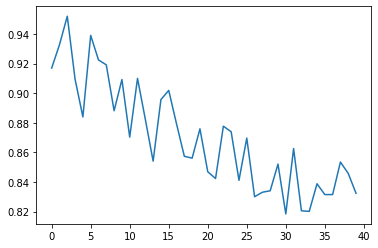

In [61]:
plt.plot(concordance_td_list)

### Comparison with baseline

In [62]:
eta = best_eta
combined_info = (zeros + eta * prior_info) / (1 + eta)
combined_info

array([[0.0016274 , 0.00069541, 0.0004277 , ..., 0.00101237, 0.00190945,
        0.00063439],
       [0.01331991, 0.00580901, 0.00359406, ..., 0.00839792, 0.01553352,
        0.0053065 ],
       [0.01371543, 0.00598568, 0.00370413, ..., 0.00865124, 0.01599149,
        0.00546814],
       ...,
       [0.00138163, 0.00059014, 0.00036291, ..., 0.00085924, 0.00162129,
        0.00053834],
       [0.00243015, 0.00103987, 0.00063982, ..., 0.00151313, 0.00285013,
        0.00094872],
       [0.00553276, 0.00238026, 0.00146682, ..., 0.0034572 , 0.00647844,
        0.00217239]])

In [ ]:
concordance_td_list = []
integrated_brier_score_list = []
integrated_nbll_list = []
likelihood_list = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  train = (x_train, y_train)
  val = (x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list.append(ev.concordance_td('antolini'))
  integrated_brier_score_list.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list.append(ev.integrated_nbll(time_grid))
  likelihood_list.append(log.to_pandas().val_loss.min())


## With a little smaller subset of covariates

In [59]:
data_prior = pd.read_csv("/content/drive/My Drive/Kevin He/prior_data_subset_2.csv")

In [60]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")

In [61]:
data_prior

,Unnamed: 0,status,Z1,Z2,Z3,Z4,Z6,Z7,Z8,Z9,time
0,1,0,-0.286215,0.139929,-0.986627,0.320499,0,1,1,1,10
1,2,0,-1.020084,0.497558,0.142357,-0.993178,1,1,1,0,10
2,3,0,-0.657176,-0.788317,-0.223124,-0.086939,1,0,1,0,2
3,4,0,1.062820,1.694089,2.028497,1.665537,0,0,0,1,10
4,5,0,1.519426,1.334383,-0.324365,-0.353265,1,0,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0,0.076944,0.584749,2.131765,1.081040,1,0,0,1,3
9996,9997,0,-0.197012,-1.493841,-1.189917,-0.810097,1,0,0,0,5
9997,9998,0,0.191691,-0.470902,-0.030415,0.251914,1,0,1,1,9
9998,9999,0,0.950740,0.634772,-0.740211,-0.000132,1,1,0,1,2


In [62]:
data_prior = data_prior.drop(['Unnamed: 0'], axis = 1)

In [63]:
data_prior_expanded = dataLong(data_prior)

In [64]:
data_prior_expanded

,status,Z1,Z2,Z3,Z4,Z6,Z7,Z8,Z9,time,...,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,0.0,-0.286215,0.139929,-0.986627,0.320499,0.0,1.0,1.0,1.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.286215,0.139929,-0.986627,0.320499,0.0,1.0,1.0,1.0,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.286215,0.139929,-0.986627,0.320499,0.0,1.0,1.0,1.0,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.286215,0.139929,-0.986627,0.320499,0.0,1.0,1.0,1.0,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-0.286215,0.139929,-0.986627,0.320499,0.0,1.0,1.0,1.0,5,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59911,0.0,-0.396628,-1.731480,-1.686023,-0.095764,1.0,0.0,0.0,1.0,6,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
59912,0.0,-0.396628,-1.731480,-1.686023,-0.095764,1.0,0.0,0.0,1.0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
59913,0.0,-0.396628,-1.731480,-1.686023,-0.095764,1.0,0.0,0.0,1.0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
59914,0.0,-0.396628,-1.731480,-1.686023,-0.095764,1.0,0.0,0.0,1.0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [65]:
columns = ["Z1", "Z2", "Z3", "Z4", "Z6", "Z7", "Z8", "Z9"] + ['time' + str(i + 1) for i in range(10)]
# X = np.array(data_prior[columns])
# y = np.array(data_prior['y'])
X = data_prior_expanded[columns]
y = data_prior_expanded["y"]

In [66]:
import statsmodels.api as sm

# train_x['intercept'] = 1.0
logit = sm.Logit(y, X)
result = logit.fit(maxiter = 10000)
result.summary()

Optimization terminated successfully.
         Current function value: 0.047001
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                59916
Model:                          Logit   Df Residuals:                    59898
Method:                           MLE   Df Model:                           17
Date:                Wed, 13 Apr 2022   Pseudo R-squ.:                  0.4838
Time:                        17:35:46   Log-Likelihood:                -2816.1
converged:                       True   LL-Null:                       -5455.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Z1            -1.5479      0.053    -29.212      0.000      -1.652      -1.444
Z2             0.7848      0.050     15.677      0.000       0.687       0.883
Z3            -1.6878      0.059    -28.795      0.000      -1.803      -1.573
Z4            -1.9389      0.059    -33.113      0.000      -2.054      -1.824
Z6            -3.3639      0.108    -31.224      0.000      -3.575      -3.153
Z7             0.8745      0.076     11.573      0.000       0.726       1.023
Z8            -2.4079      0.092    -26.136      0.000      -2.588      -2.227
Z9            -3.3363      0.108    -30.887      0.000      -3.548      -3.125
time1         -4.5957      0.128    -35.930      0.000      -4.846      -4.345
time2         -4.7979      0.137    -35.066      0.000      -5.066      -4.530
time3         -5.0184      0.157    -32.007      0.000      -5.326      -4.711
time4         -3.6387      0.121    -30.139      0.000      -3.875      -3.402
time5         -3.8012      0.142    -26.843      0.000      -4.079      -3.524
time6         -3.7738      0.158    -23.829      0.000      -4.084      -3.463
time7         -2.5402      0.128    -19.841      0.000      -2.791      -2.289
time8         -2.6804      0.159    -16.888      0.000      -2.991      -2.369
time9         -1.7058      0.145    -11.757      0.000      -1.990      -1.421
time10        -2.6346      0.266     -9.909      0.000      -3.156      -2.113
==============================================================================

Possibly complete quasi-separation: A fraction 0.43 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [67]:
time_column = ["time" + str(i + 1) for i in range(10)]
cova_column = ["Z1", "Z2", "Z3", "Z4", "Z6", "Z7", "Z8", "Z9"]

beta_time = np.array(result.params[time_column])
beta_cova = np.array(result.params[cova_column])

In [68]:
Z = np.array(data_local[cova_column])
Z.shape

(300, 8)

In [69]:
prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

In [70]:
time = data_local["time"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 11))
np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
zeros = zeros[:, 1:]
zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
eta = 10
combined_info = (zeros + eta * prior_info) / (1 + eta)
combined_info

array([[2.34241665e-03, 1.91452768e-03, 1.53632817e-03, ...,
        1.56699765e-02, 4.03757649e-02, 1.63908710e-02],
       [8.84948928e-05, 7.22967138e-05, 5.79918171e-05, ...,
        6.00493678e-04, 1.58952197e-03, 6.28607064e-04],
       [4.11105229e-03, 3.36128449e-03, 2.69813986e-03, ...,
        2.71996943e-02, 6.86860746e-02, 2.84341301e-02],
       ...,
       [1.24735114e-08, 1.01901679e-08, 8.17377475e-09, ...,
        8.46883383e-08, 2.24416452e-07, 8.86559455e-08],
       [4.08356869e-03, 3.33879482e-03, 2.68007402e-03, ...,
        2.70224653e-02, 6.82594497e-02, 2.82491153e-02],
       [1.26857655e-02, 1.03901084e-02, 8.35304262e-03, ...,
        7.96913291e-02, 1.84491507e-01, 8.30836174e-02]])

In [72]:
combined_info.shape

(300, 10)

### Cross Validation

In [73]:
from sklearn.model_selection import KFold # import KFold

In [74]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")

In [75]:
# Due to the starter number difference between Python and R
data_local['time'] = data_local['time'] - 1

In [76]:
# Standardize for continuous data, remaining the same for categorical data

cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

data_local_mapper = DataFrameMapper(standardize + leave)

In [77]:
# CHANGE HERE!

data_local_test = data_local.sample(frac=0.2)
data_local_train = data_local.drop(data_local_test.index)
# data_local_val = data_local_train.sample(frac=0.2)
# data_local_train = data_local_train.drop(data_local_val.index)
data_local = data_local_train.copy()

In [78]:
# # Devide training data into another "training, test, val" data.

# data_local_train_test = data_local_train.sample(frac=0.2)
# data_local_train_train = data_local_train.drop(data_local_train_test.index)
# data_local_train_val = data_local_train_train.sample(frac=0.2)
# data_local_train_train = data_local_train_train.drop(data_local_train_val.index)

# data_local_train_train

In [79]:
data_local_index = np.array(data_local.index)
# data_local_val_index = np.array(data_local_val.index)
combined_info_train = combined_info[data_local_index]

In [80]:
combined_info_train.shape

(240, 10)

In [81]:
x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
# x_val = data_local_mapper.transform(data_local_val).astype('float32')
x_test = data_local_mapper.transform(data_local_test).astype('float32')
X_train = x_train.copy()

In [82]:
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(X_train) # returns the number of splitting iterations in the cross-validator

5

In [128]:
eta_list = [i / 4 for i in range(40)]

best_eta = 0
best_concordance = 0
best_ibs = 1000
best_ibll = 1000
concordance_td_list = []
integrated_brier_score_list = []
integrated_nbll_list = []
for eta in eta_list:
  concordance_td_list_CV = []
  integrated_brier_score_list_CV = []
  integrated_nbll_list_CV = []
  likelihood_list_CV = []

  combined_info = (zeros + eta * prior_info) / (1 + eta)

  data_local_index = np.array(data_local.index)
  combined_info_train = combined_info[data_local_index]

  for train_index, test_index in kf.split(X_train):
    data_local_train_index = train_index
    data_local_val_index = test_index
    data_local_train = data_local.iloc[data_local_train_index,]
    data_local_val = data_local.iloc[data_local_val_index,]
    x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
    x_val = data_local_mapper.transform(data_local_val).astype('float32')
    n_train = data_local_train.shape[0]
    n_val = data_local_val.shape[0]
    y_train = (combined_info_train[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
    y_val = (combined_info_train[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)

    train = (x_train, y_train)
    val = (x_val, y_val)
    labtrans = LogisticHazard.label_transform(num_durations)

    get_target = lambda df: (df['time'].values, df['status'].values)

    batch_size = 20
    epochs = 100
    callbacks = [tt.cb.EarlyStopping()]

    durations_test, events_test = get_target(data_local_val)

    num_durations = 10
    in_features = x_train.shape[1]
    num_nodes = [32, 32]
    out_features = num_durations
    batch_norm = True
    dropout = 0.1

    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

    # We don't need to transform the test labels
    # durations_test, events_test = get_target(data_local_train_test)

    model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

    log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
    surv = model.predict_surv_df(x_val)
    ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
    concordance_td_list_CV.append(ev.concordance_td('antolini'))
    integrated_brier_score_list_CV.append(ev.integrated_brier_score(time_grid))
    integrated_nbll_list_CV.append(ev.integrated_nbll(time_grid))
    likelihood_list_CV.append(log.to_pandas().val_loss.min())
  
  concordance_td = sum(concordance_td_list_CV) / len(concordance_td_list_CV)
  integrated_brier_score = sum(integrated_brier_score_list_CV) / len(integrated_brier_score_list_CV)
  integrated_nbll = sum(integrated_nbll_list_CV) / len(integrated_nbll_list_CV)
  integrated_nbll_list.append(integrated_nbll)
  concordance_td_list.append(concordance_td)
  integrated_brier_score_list.append(integrated_brier_score)
  if(best_ibll > integrated_nbll):
    best_ibll = integrated_nbll
    best_eta = eta

best_eta


流式输出内容被截断，只能显示最后 5000 行内容。
1:	[0s / 0s],		train_loss: 3.2096,	val_loss: 2.6453
2:	[0s / 0s],		train_loss: 2.0095,	val_loss: 1.5378
3:	[0s / 0s],		train_loss: 0.9640,	val_loss: 0.6876
4:	[0s / 0s],		train_loss: 0.4826,	val_loss: 0.4576
5:	[0s / 0s],		train_loss: 0.3368,	val_loss: 0.3725
6:	[0s / 0s],		train_loss: 0.3097,	val_loss: 0.3294
7:	[0s / 0s],		train_loss: 0.2766,	val_loss: 0.3165
8:	[0s / 0s],		train_loss: 0.2651,	val_loss: 0.3026
9:	[0s / 0s],		train_loss: 0.2533,	val_loss: 0.2842
10:	[0s / 0s],		train_loss: 0.2502,	val_loss: 0.2749
11:	[0s / 0s],		train_loss: 0.2502,	val_loss: 0.2633
12:	[0s / 0s],		train_loss: 0.2658,	val_loss: 0.2622
13:	[0s / 0s],		train_loss: 0.2493,	val_loss: 0.2634
14:	[0s / 0s],		train_loss: 0.2642,	val_loss: 0.2548
15:	[0s / 0s],		train_loss: 0.2455,	val_loss: 0.2592
16:	[0s / 0s],		train_loss: 0.2526,	val_loss: 0.2608
17:	[0s / 0s],		train_loss: 0.2549,	val_loss: 0.2627
18:	[0s / 0s],		train_loss: 0.2612,	val_loss: 0.2578
19:	[0s / 0s],		train_loss: 

1.25

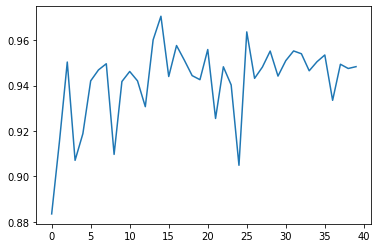

In [129]:
plt.plot(concordance_td_list)

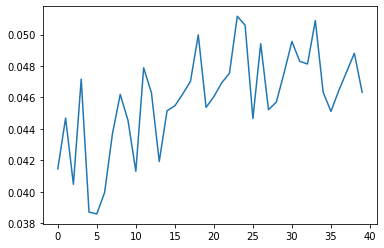

In [130]:
plt.plot(integrated_brier_score_list)

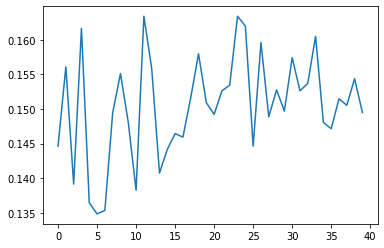

In [131]:
plt.plot(integrated_nbll_list)

### Comparison with baseline

In [132]:
eta = best_eta
combined_info = (zeros + eta * prior_info) / (1 + eta)
combined_info

array([[4.27107788e-03, 1.46438324e-03, 1.09253429e-03, ...,
        2.30203731e-03, 5.11986915e-03, 3.18113271e-03],
       [7.83042300e-04, 2.67362516e-04, 1.99362133e-04, ...,
        4.20818805e-04, 9.39838028e-04, 5.82275962e-04],
       [2.67227149e-03, 9.14473126e-04, 6.82090249e-04, ...,
        1.43838510e-03, 3.20517928e-03, 1.98885708e-03],
       ...,
       [2.60054412e-05, 8.87134387e-06, 6.61424305e-06, ...,
        1.39669020e-05, 3.12212798e-05, 1.93310723e-05],
       [8.87540163e-03, 3.05981686e-03, 2.28451184e-03, ...,
        4.80217877e-03, 1.06215805e-02, 6.62458899e-03],
       [1.31986832e-02, 4.57398067e-03, 3.41738565e-03, ...,
        7.16737275e-03, 1.57709023e-02, 9.87127832e-03]])

In [133]:
# CHANGE HERE!
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")

data_local['time'] = data_local['time'] - 1

data_local_test = data_local.sample(frac=0.2)
data_local_train = data_local.drop(data_local_test.index)
data_local_val = data_local_train.sample(frac=0.2)
data_local_train = data_local_train.drop(data_local_val.index)
# data_local = data_local_train.copy()

In [134]:
data_local_train_index = np.array(data_local_train.index)
data_local_val_index = np.array(data_local_val.index)

In [135]:
concordance_td_list = []
integrated_brier_score_list = []
integrated_nbll_list = []
likelihood_list = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
  x_val = data_local_mapper.transform(data_local_val).astype('float32')
  x_test = data_local_mapper.transform(data_local_test).astype('float32')
  train = (x_train, y_train)
  val = (x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list.append(ev.concordance_td('antolini'))
  integrated_brier_score_list.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list.append(ev.integrated_nbll(time_grid))
  likelihood_list.append(log.to_pandas().val_loss.min())


1
0:	[0s / 0s],		train_loss: 4.1790,	val_loss: 3.4964
1:	[0s / 0s],		train_loss: 3.2853,	val_loss: 2.4383
2:	[0s / 0s],		train_loss: 2.0089,	val_loss: 1.2515
3:	[0s / 0s],		train_loss: 0.9717,	val_loss: 0.6716
4:	[0s / 0s],		train_loss: 0.5005,	val_loss: 0.5072
5:	[0s / 0s],		train_loss: 0.3768,	val_loss: 0.4477
6:	[0s / 0s],		train_loss: 0.3187,	val_loss: 0.3906
7:	[0s / 0s],		train_loss: 0.3788,	val_loss: 0.4312
8:	[0s / 0s],		train_loss: 0.3304,	val_loss: 0.4127
9:	[0s / 0s],		train_loss: 0.3174,	val_loss: 0.3557
10:	[0s / 0s],		train_loss: 0.3031,	val_loss: 0.3499
11:	[0s / 0s],		train_loss: 0.2902,	val_loss: 0.3439
12:	[0s / 0s],		train_loss: 0.2880,	val_loss: 0.3602
13:	[0s / 0s],		train_loss: 0.3074,	val_loss: 0.3475
14:	[0s / 0s],		train_loss: 0.2858,	val_loss: 0.2992
15:	[0s / 0s],		train_loss: 0.2936,	val_loss: 0.3128
16:	[0s / 0s],		train_loss: 0.2810,	val_loss: 0.3310
17:	[0s / 0s],		train_loss: 0.2703,	val_loss: 0.3126
18:	[0s / 0s],		train_loss: 0.2754,	val_loss: 0.3157
1

In [136]:
concordance_td_list_old = []
integrated_brier_score_list_old = []
integrated_nbll_list_old = []
likelihood_list_old = []

x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
x_val = data_local_mapper.transform(data_local_val).astype('float32')
x_test = data_local_mapper.transform(data_local_test).astype('float32')

for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  y_train = labtrans.fit_transform(*get_target(data_local_train))
  y_val = labtrans.transform(*get_target(data_local_val))
  train = (x_train, y_train)
  val = (x_val, y_val)


  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list_old.append(ev.concordance_td('antolini'))
  integrated_brier_score_list_old.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old.append(ev.integrated_nbll(time_grid))
  likelihood_list_old.append(log.to_pandas().val_loss.min())

0:	[0s / 0s],		train_loss: 4.1897,	val_loss: 3.5112
1:	[0s / 0s],		train_loss: 3.2294,	val_loss: 2.5492
2:	[0s / 0s],		train_loss: 2.0898,	val_loss: 1.3485
3:	[0s / 0s],		train_loss: 1.0231,	val_loss: 0.7720
4:	[0s / 0s],		train_loss: 0.5415,	val_loss: 0.6573
5:	[0s / 0s],		train_loss: 0.4283,	val_loss: 0.5936
6:	[0s / 0s],		train_loss: 0.3275,	val_loss: 0.4380
7:	[0s / 0s],		train_loss: 0.3173,	val_loss: 0.4401
8:	[0s / 0s],		train_loss: 0.3124,	val_loss: 0.4989
9:	[0s / 0s],		train_loss: 0.2820,	val_loss: 0.5036
10:	[0s / 0s],		train_loss: 0.2628,	val_loss: 0.5438
11:	[0s / 0s],		train_loss: 0.3294,	val_loss: 0.6251
12:	[0s / 0s],		train_loss: 0.2485,	val_loss: 0.5476
13:	[0s / 0s],		train_loss: 0.2872,	val_loss: 0.5745
14:	[0s / 0s],		train_loss: 0.1997,	val_loss: 0.5785
15:	[0s / 0s],		train_loss: 0.2038,	val_loss: 0.6079
16:	[0s / 0s],		train_loss: 0.2746,	val_loss: 0.7503
0:	[0s / 0s],		train_loss: 4.2461,	val_loss: 3.6419
1:	[0s / 0s],		train_loss: 3.3342,	val_loss: 2.6678
2:	[0

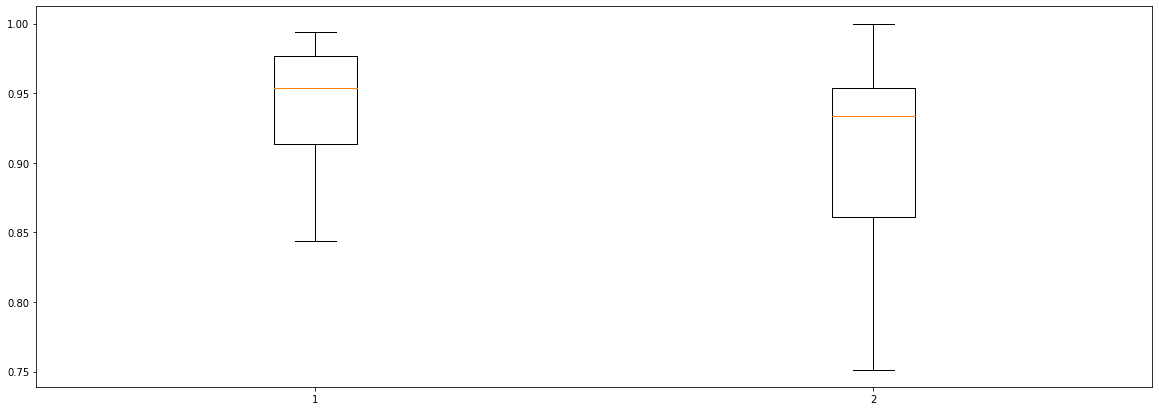

In [137]:
fig = plt.figure(figsize =(20, 7))

# Creating plot
concordance_td_array = np.array(concordance_td_list)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list)
integrated_nbll_array = np.array(integrated_nbll_list)
integrated_nbll_array_old = np.array(integrated_nbll_list_old)
likelihood_array = np.array(likelihood_list)
likelihood_array_old = np.array(likelihood_list_old)

plt.boxplot([concordance_td_array, concordance_td_array_old])

# show plot
plt.show()

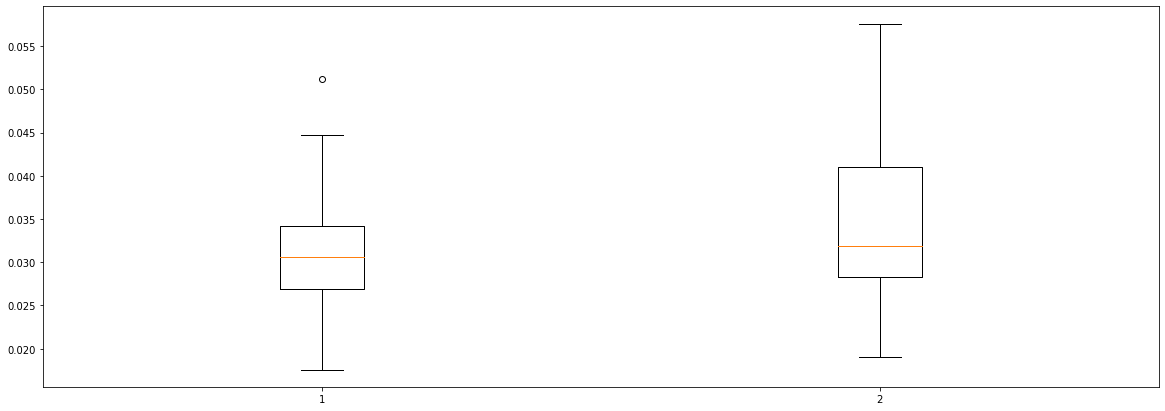

In [138]:
fig = plt.figure(figsize =(20, 7))
plt.boxplot([integrated_brier_score_array, integrated_brier_score_array_old])

# show plot
plt.show()

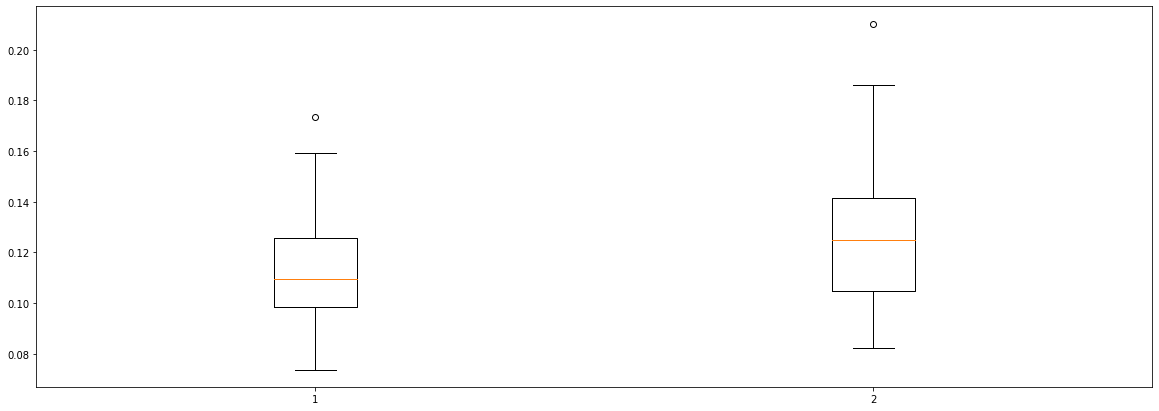

In [139]:
fig = plt.figure(figsize =(20, 7))
plt.boxplot([integrated_nbll_array, integrated_nbll_array_old])

# show plot
plt.show()

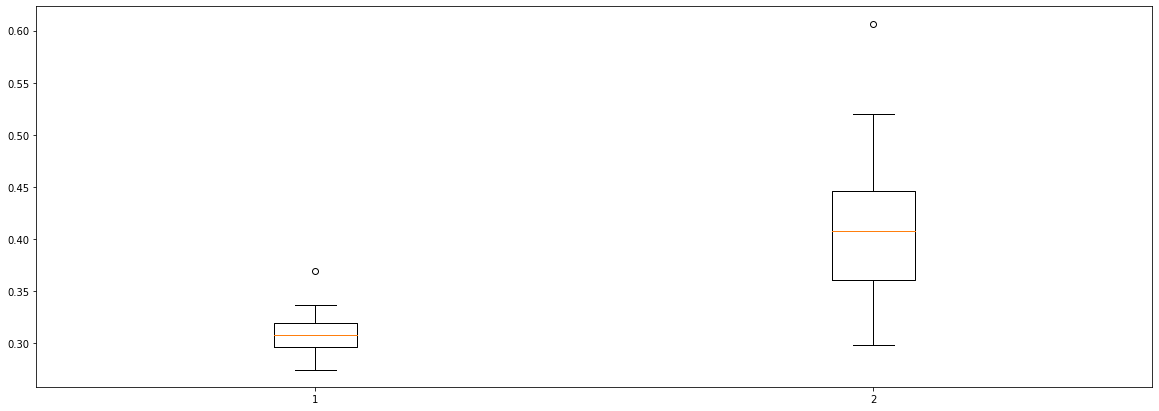

In [140]:
fig = plt.figure(figsize =(20, 7))
plt.boxplot([likelihood_array, likelihood_array_old])

# show plot
plt.show()

## With noise info from prior

In [141]:
data_prior = pd.read_csv("/content/drive/My Drive/Kevin He/prior_data_subset_3.csv")

In [142]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")

In [143]:
data_prior

,Unnamed: 0,status,Z1,Z2,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z12,time
0,1,0,0.380164,-0.241142,1.045101,1.549094,-0.002985,1,1,0,1,0,3
1,2,0,1.300797,-0.801364,1.465903,0.161927,-0.832144,1,1,0,1,0,7
2,3,0,0.642064,2.001553,0.689195,0.501743,0.844910,0,0,0,0,1,5
3,4,0,-0.586698,-0.737862,-0.211485,-1.370413,-0.191788,1,0,1,1,0,9
4,5,0,-1.103125,-2.244228,1.271024,1.037505,1.282007,0,0,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0,0.103067,-0.579165,-0.156072,0.674152,-0.182739,1,0,1,0,0,8
9996,9997,0,-0.760338,1.061029,0.982780,-0.186722,-0.739017,0,1,1,1,0,5
9997,9998,0,0.122932,0.123536,0.279094,1.547626,1.446756,1,0,0,1,1,9
9998,9999,0,0.534601,-0.253407,1.875504,-0.853564,2.082054,1,0,0,1,0,10


In [144]:
data_prior = data_prior.drop(['Unnamed: 0'], axis = 1)

In [145]:
data_prior_expanded = dataLong(data_prior)

In [146]:
data_prior_expanded

,status,Z1,Z2,Z4,Z5,Z6,Z7,Z8,Z9,Z10,...,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,0.0,0.380164,-0.241142,1.045101,1.549094,-0.002985,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.380164,-0.241142,1.045101,1.549094,-0.002985,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.380164,-0.241142,1.045101,1.549094,-0.002985,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.300797,-0.801364,1.465903,0.161927,-0.832144,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.300797,-0.801364,1.465903,0.161927,-0.832144,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55650,0.0,-0.517134,0.310197,0.557575,1.093622,0.663782,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55651,0.0,-0.517134,0.310197,0.557575,1.093622,0.663782,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55652,0.0,-0.517134,0.310197,0.557575,1.093622,0.663782,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
55653,0.0,-0.517134,0.310197,0.557575,1.093622,0.663782,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [147]:
columns = ["Z1", "Z2", "Z4", "Z5", "Z6", "Z7", "Z8", "Z9", "Z10", "Z12"] + ['time' + str(i + 1) for i in range(10)]
# X = np.array(data_prior[columns])
# y = np.array(data_prior['y'])
X = data_prior_expanded[columns]
y = data_prior_expanded["y"]

In [148]:
import statsmodels.api as sm

# train_x['intercept'] = 1.0
logit = sm.Logit(y, X)
result = logit.fit(maxiter = 10000)
result.summary()

Optimization terminated successfully.
         Current function value: 0.085502
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                55655
Model:                          Logit   Df Residuals:                    55635
Method:                           MLE   Df Model:                           19
Date:                Wed, 13 Apr 2022   Pseudo R-squ.:                  0.4065
Time:                        18:19:16   Log-Likelihood:                -4758.6
converged:                       True   LL-Null:                       -8018.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Z1            -0.8391      0.035    -24.063      0.000      -0.907      -0.771
Z2             0.0674      0.033      2.034      0.042       0.002       0.132
Z4            -1.5580      0.042    -37.295      0.000      -1.640      -1.476
Z5             0.3838      0.038     10.186      0.000       0.310       0.458
Z6            -1.6840      0.042    -39.930      0.000      -1.767      -1.601
Z7             0.3256      0.057      5.726      0.000       0.214       0.437
Z8            -1.2998      0.061    -21.258      0.000      -1.420      -1.180
Z9            -1.7885      0.064    -27.800      0.000      -1.915      -1.662
Z10            0.4865      0.057      8.496      0.000       0.374       0.599
Z12            0.9197      0.059     15.685      0.000       0.805       1.035
time1         -3.7662      0.091    -41.400      0.000      -3.944      -3.588
time2         -4.8417      0.110    -44.033      0.000      -5.057      -4.626
time3         -5.1353      0.126    -40.823      0.000      -5.382      -4.889
time4         -4.2012      0.107    -39.280      0.000      -4.411      -3.992
time5         -4.7479      0.133    -35.574      0.000      -5.010      -4.486
time6         -4.7664      0.147    -32.495      0.000      -5.054      -4.479
time7         -4.1200      0.134    -30.668      0.000      -4.383      -3.857
time8         -4.3878      0.168    -26.121      0.000      -4.717      -4.059
time9         -3.5834      0.153    -23.472      0.000      -3.883      -3.284
time10        -4.0628      0.228    -17.789      0.000      -4.510      -3.615
==============================================================================
"""

In [149]:
time_column = ["time" + str(i + 1) for i in range(10)]
cova_column = ["Z1", "Z2", "Z4", "Z5", "Z6", "Z7", "Z8", "Z9", "Z10"]

beta_time = np.array(result.params[time_column])
beta_cova = np.array(result.params[cova_column])

In [150]:
Z = np.array(data_local[cova_column])
Z.shape

(300, 9)

In [151]:
prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

In [152]:
time = data_local["time"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 11))
np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
zeros = zeros[:, 1:]
zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [153]:
eta = 10
combined_info = (zeros + eta * prior_info) / (1 + eta)
combined_info

array([[6.98903653e-03, 2.39626349e-03, 1.78778339e-03, ...,
        3.76697015e-03, 8.37796770e-03, 5.20548989e-03],
       [1.28134195e-03, 4.37502300e-04, 3.26228945e-04, ...,
        6.88612591e-04, 1.53791677e-03, 9.52815211e-04],
       [4.37280790e-03, 1.49641057e-03, 1.11614768e-03, ...,
        2.35372107e-03, 5.24483882e-03, 3.25449340e-03],
       ...,
       [4.25543583e-05, 1.45167445e-05, 1.08233068e-05, ...,
        2.28549305e-05, 5.10893669e-05, 3.16326637e-05],
       [1.45233845e-02, 5.00697304e-03, 3.73829210e-03, ...,
        7.85811071e-03, 1.73807681e-02, 1.08402365e-02],
       [2.15978452e-02, 7.48469564e-03, 5.59208561e-03, ...,
        1.17284281e-02, 2.58069310e-02, 1.61530009e-02]])

In [154]:
combined_info.shape

(300, 10)

### Cross Validation

In [155]:
from sklearn.model_selection import KFold # import KFold

In [156]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")

In [157]:
# Due to the starter number difference between Python and R
data_local['time'] = data_local['time'] - 1

In [158]:
# Standardize for continuous data, remaining the same for categorical data

cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

data_local_mapper = DataFrameMapper(standardize + leave)

In [159]:
# CHANGE HERE!

data_local_test = data_local.sample(frac=0.2)
data_local_train = data_local.drop(data_local_test.index)
# data_local_val = data_local_train.sample(frac=0.2)
# data_local_train = data_local_train.drop(data_local_val.index)
data_local = data_local_train.copy()

In [160]:
# # Devide training data into another "training, test, val" data.

# data_local_train_test = data_local_train.sample(frac=0.2)
# data_local_train_train = data_local_train.drop(data_local_train_test.index)
# data_local_train_val = data_local_train_train.sample(frac=0.2)
# data_local_train_train = data_local_train_train.drop(data_local_train_val.index)

# data_local_train_train

In [161]:
data_local_index = np.array(data_local.index)
# data_local_val_index = np.array(data_local_val.index)
combined_info_train = combined_info[data_local_index]

In [162]:
combined_info_train.shape

(240, 10)

In [163]:
x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
# x_val = data_local_mapper.transform(data_local_val).astype('float32')
x_test = data_local_mapper.transform(data_local_test).astype('float32')
X_train = x_train.copy()

In [164]:
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(X_train) # returns the number of splitting iterations in the cross-validator

5

In [ ]:
eta_list = [i / 4 for i in range(40)]

best_eta = 0
best_concordance = 0
best_ibs = 1000
best_ibll = 1000
concordance_td_list = []
integrated_brier_score_list = []
integrated_nbll_list = []
for eta in eta_list:
  concordance_td_list_CV = []
  integrated_brier_score_list_CV = []
  integrated_nbll_list_CV = []
  likelihood_list_CV = []

  combined_info = (zeros + eta * prior_info) / (1 + eta)

  data_local_index = np.array(data_local.index)
  combined_info_train = combined_info[data_local_index]

  for train_index, test_index in kf.split(X_train):
    data_local_train_index = train_index
    data_local_val_index = test_index
    data_local_train = data_local.iloc[data_local_train_index,]
    data_local_val = data_local.iloc[data_local_val_index,]
    x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
    x_val = data_local_mapper.transform(data_local_val).astype('float32')
    n_train = data_local_train.shape[0]
    n_val = data_local_val.shape[0]
    y_train = (combined_info_train[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
    y_val = (combined_info_train[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)

    train = (x_train, y_train)
    val = (x_val, y_val)
    labtrans = LogisticHazard.label_transform(num_durations)

    get_target = lambda df: (df['time'].values, df['status'].values)

    batch_size = 20
    epochs = 100
    callbacks = [tt.cb.EarlyStopping()]

    durations_test, events_test = get_target(data_local_val)

    num_durations = 10
    in_features = x_train.shape[1]
    num_nodes = [32, 32]
    out_features = num_durations
    batch_norm = True
    dropout = 0.1

    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

    # We don't need to transform the test labels
    # durations_test, events_test = get_target(data_local_train_test)

    model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

    log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
    surv = model.predict_surv_df(x_val)
    ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
    concordance_td_list_CV.append(ev.concordance_td('antolini'))
    integrated_brier_score_list_CV.append(ev.integrated_brier_score(time_grid))
    integrated_nbll_list_CV.append(ev.integrated_nbll(time_grid))
    likelihood_list_CV.append(log.to_pandas().val_loss.min())
  
  concordance_td = sum(concordance_td_list_CV) / len(concordance_td_list_CV)
  integrated_brier_score = sum(integrated_brier_score_list_CV) / len(integrated_brier_score_list_CV)
  integrated_nbll = sum(integrated_nbll_list_CV) / len(integrated_nbll_list_CV)
  integrated_nbll_list.append(integrated_nbll)
  concordance_td_list.append(concordance_td)
  integrated_brier_score_list.append(integrated_brier_score)
  if(best_ibll > integrated_nbll):
    best_ibll = integrated_nbll
    best_eta = eta

best_eta


1
0:	[0s / 0s],		train_loss: 4.0226,	val_loss: 4.0074
1:	[0s / 0s],		train_loss: 3.1911,	val_loss: 2.9006
2:	[0s / 0s],		train_loss: 2.1406,	val_loss: 1.8617
3:	[0s / 0s],		train_loss: 1.1737,	val_loss: 1.0705
4:	[0s / 0s],		train_loss: 0.5951,	val_loss: 0.6193
5:	[0s / 0s],		train_loss: 0.3624,	val_loss: 0.5458
6:	[0s / 0s],		train_loss: 0.3244,	val_loss: 0.5206
7:	[0s / 0s],		train_loss: 0.2983,	val_loss: 0.4945
8:	[0s / 0s],		train_loss: 0.3202,	val_loss: 0.4705
9:	[0s / 0s],		train_loss: 0.2670,	val_loss: 0.4475
10:	[0s / 0s],		train_loss: 0.2353,	val_loss: 0.4654
11:	[0s / 0s],		train_loss: 0.2318,	val_loss: 0.4936
12:	[0s / 0s],		train_loss: 0.1900,	val_loss: 0.4674
13:	[0s / 0s],		train_loss: 0.2156,	val_loss: 0.4782
14:	[0s / 0s],		train_loss: 0.2072,	val_loss: 0.4800
15:	[0s / 0s],		train_loss: 0.1782,	val_loss: 0.4918
16:	[0s / 0s],		train_loss: 0.1945,	val_loss: 0.5026
17:	[0s / 0s],		train_loss: 0.1697,	val_loss: 0.4908
18:	[0s / 0s],		train_loss: 0.1933,	val_loss: 0.5177
1

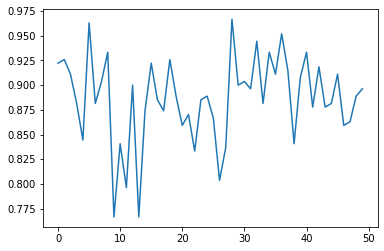

In [178]:
plt.plot(concordance_td_list)

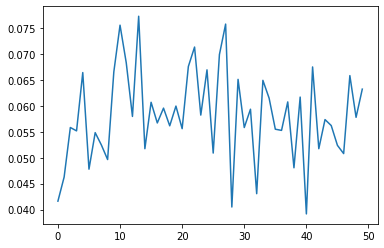

In [179]:
plt.plot(integrated_brier_score_list)

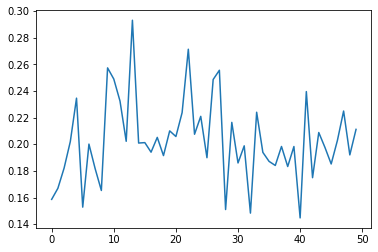

In [180]:
plt.plot(integrated_nbll_list)

### Comparison with baseline

In [ ]:
eta = best_eta
combined_info = (zeros + eta * prior_info) / (1 + eta)
combined_info

In [ ]:
# CHANGE HERE!
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")

data_local['time'] = data_local['time'] - 1

data_local_test = data_local.sample(frac=0.2)
data_local_train = data_local.drop(data_local_test.index)
data_local_val = data_local_train.sample(frac=0.2)
data_local_train = data_local_train.drop(data_local_val.index)
# data_local = data_local_train.copy()

In [ ]:
data_local_train_index = np.array(data_local_train.index)
data_local_val_index = np.array(data_local_val.index)

In [ ]:
concordance_td_list = []
integrated_brier_score_list = []
integrated_nbll_list = []
likelihood_list = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
  x_val = data_local_mapper.transform(data_local_val).astype('float32')
  x_test = data_local_mapper.transform(data_local_test).astype('float32')
  y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  train = (x_train, y_train)
  val = (x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list.append(ev.concordance_td('antolini'))
  integrated_brier_score_list.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list.append(ev.integrated_nbll(time_grid))
  likelihood_list.append(log.to_pandas().val_loss.min())


In [ ]:
concordance_td_list_old = []
integrated_brier_score_list_old = []
integrated_nbll_list_old = []
likelihood_list_old = []
for i in range(50):
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
  x_val = data_local_mapper.transform(data_local_val).astype('float32')
  x_test = data_local_mapper.transform(data_local_test).astype('float32')
  y_train = labtrans.fit_transform(*get_target(data_local_train))
  y_val = labtrans.transform(*get_target(data_local_val))
  train = (x_train, y_train)
  val = (x_val, y_val)


  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list_old.append(ev.concordance_td('antolini'))
  integrated_brier_score_list_old.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old.append(ev.integrated_nbll(time_grid))
  likelihood_list_old.append(log.to_pandas().val_loss.min())

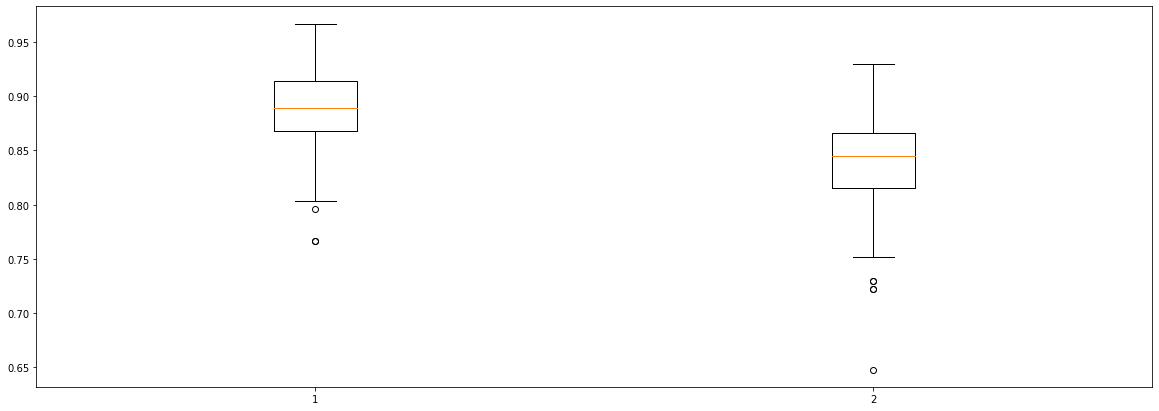

In [181]:
fig = plt.figure(figsize =(20, 7))

# Creating plot
concordance_td_array = np.array(concordance_td_list)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list)
integrated_nbll_array = np.array(integrated_nbll_list)
integrated_nbll_array_old = np.array(integrated_nbll_list_old)
likelihood_array = np.array(likelihood_list)
likelihood_array_old = np.array(likelihood_list_old)

plt.boxplot([concordance_td_array, concordance_td_array_old])

# show plot
plt.show()

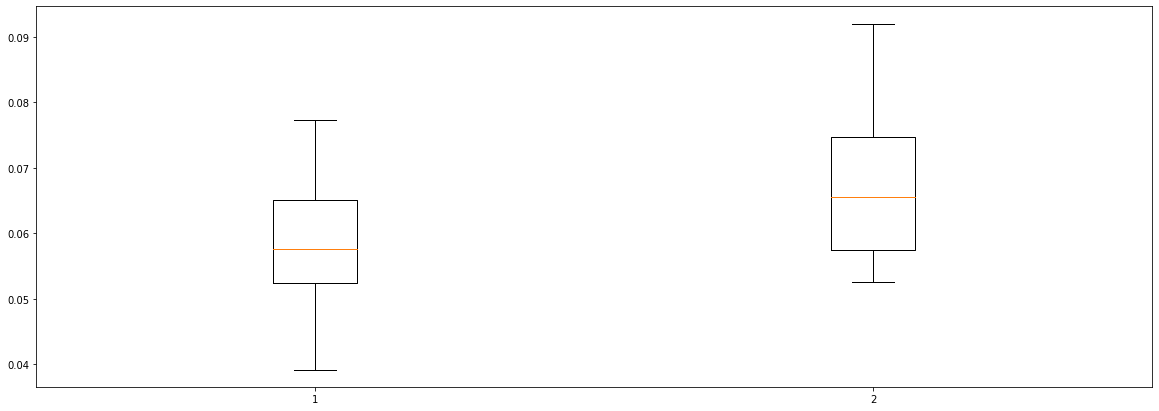

In [182]:
fig = plt.figure(figsize =(20, 7))
plt.boxplot([integrated_brier_score_array, integrated_brier_score_array_old])

# show plot
plt.show()

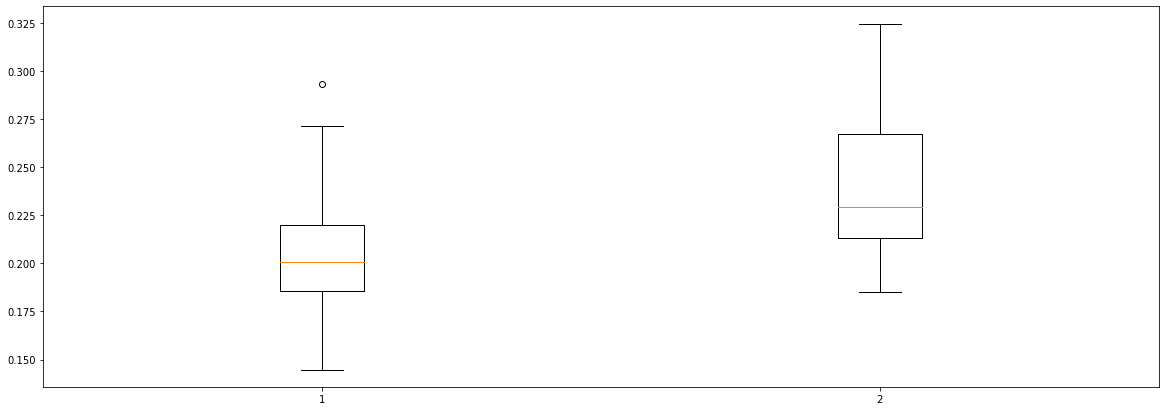

In [183]:
fig = plt.figure(figsize =(20, 7))
plt.boxplot([integrated_nbll_array, integrated_nbll_array_old])

# show plot
plt.show()

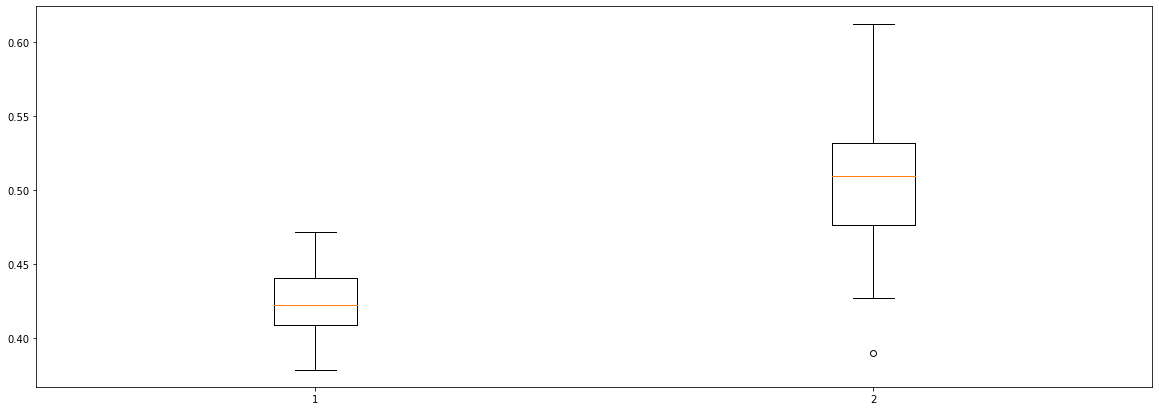

In [184]:
fig = plt.figure(figsize =(20, 7))
plt.boxplot([likelihood_array, likelihood_array_old])

# show plot
plt.show()

# Appendix

## Comparison

In [ ]:
import torch.nn.functional as F 
events = y_train[1]
idx_durations = y_train[0]
events = torch.tensor(events)
idx_durations = torch.tensor(idx_durations)

events = events.reshape(-1, 1)
idx_durations = idx_durations.reshape(-1, 1)
phi = torch.ones(192, 10) / 10
y_bce = torch.zeros_like(phi).scatter(1, idx_durations, events) # TODO: Data Expansion!
bce = F.binary_cross_entropy_with_logits(phi, y_bce, reduction='none')
loss = bce.cumsum(1).gather(1, idx_durations).view(-1)

In [ ]:
y_bce[0, 7]

tensor(0.)

In [ ]:
loss.mean()

tensor(4.4355)

In [ ]:
events = y_train[1]
idx_durations = y_train[0]
events = torch.tensor(events)
idx_durations = torch.tensor(idx_durations)
combined_info_train = torch.tensor(combined_info[data_local_train_index])

events = events.view(-1, 1)
idx_durations = idx_durations.view(-1, 1)
phi = torch.ones(192, 10) / 10
# y_bce = torch.zeros_like(phi).scatter(1, idx_durations, events)  # TODO: Data Expansion!
bce = F.binary_cross_entropy_with_logits(phi, combined_info_train, reduction='none')
loss = bce.cumsum(1).gather(1, idx_durations).view(-1)

In [ ]:
loss.mean()

tensor(4.4355, dtype=torch.float64)